In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.8 MB/s eta 0:00:00


In [154]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
plt.style.use('default')
import pandas as pd
import scipy
from scipy.spatial import voronoi_plot_2d

In [2]:
mnist=load_dataset('mnist')

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
dataset=[np.ravel(np.asarray(x,dtype=np.float64)) for x in mnist['train']['image']]
X=np.array(dataset).T
mean=X.mean(axis=1)
X=(X.T-mean).T

In [22]:
test_data=[np.ravel(np.asarray(x,dtype=np.float64)) for x in mnist['test']['image']]

In [18]:
d=X.shape[0]
n=X.shape[1]

In [19]:
C= (1/n)*X@X.T
eig_val,eig_vec=np.linalg.eigh(C)
eig_val=np.flip(eig_val)
eig_vec=np.flip(eig_vec,axis=1)


In [20]:
principal_comp=[]
for i in range(d):
  eig_vec_reshaped=eig_vec[:,i].reshape((28,28))
  principal_comp.append(eig_vec_reshaped)

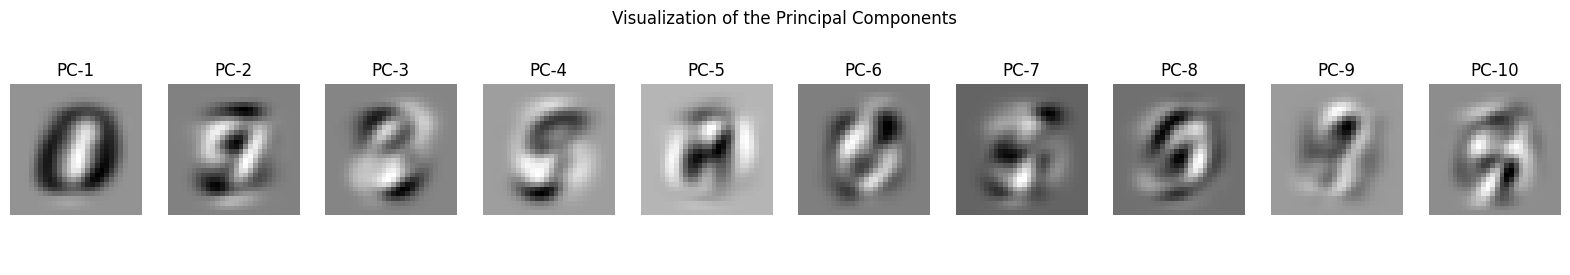

In [168]:
fig=plt.figure(figsize=(20,3))
plt.title("Visualization of the Principal Components",x=0.5,y=1.01)
plt.axis('off')
for i,comp in enumerate(principal_comp[:10]):
  fig.add_subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(comp,cmap='gray')
  plt.title(f"PC-{i+1}")


In [23]:
pc_variance=[]
for comp in principal_comp:
  sum=0
  for i in range(n):
    img=X[:,i]
    flat_comp=np.ravel(comp)
    proj=np.dot(flat_comp,img)**2
    sum+=proj/n
  pc_variance.append(sum)   # also same as the eig_val

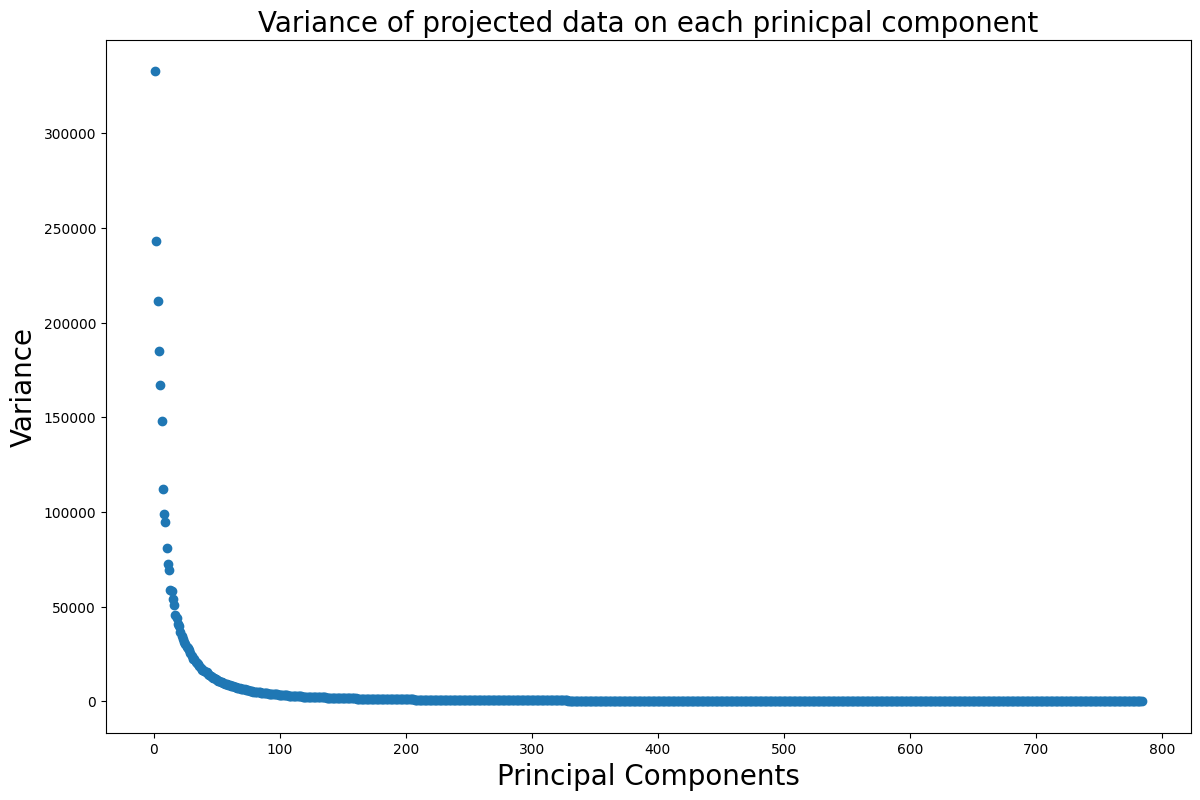

In [24]:
plt.figure(figsize=(14,9))
plt.scatter(1+np.arange(d),pc_variance)
plt.xlabel("Principal Components",fontsize=20)
plt.ylabel("Variance",fontsize=20)
plt.title("Variance of projected data on each prinicpal component",fontsize=20)
plt.show()

In [25]:
sum=0
total_sum=np.sum(eig_val)
for i in range(d):
  sum+=eig_val[i]
  ratio=sum/total_sum
  if ratio>=0.95: 
    k=i+1
    break  
print(f"Ideal choice for the dimension of the compressed representation: {k} ")

Ideal choice for the dimension of the compressed representation: 154 


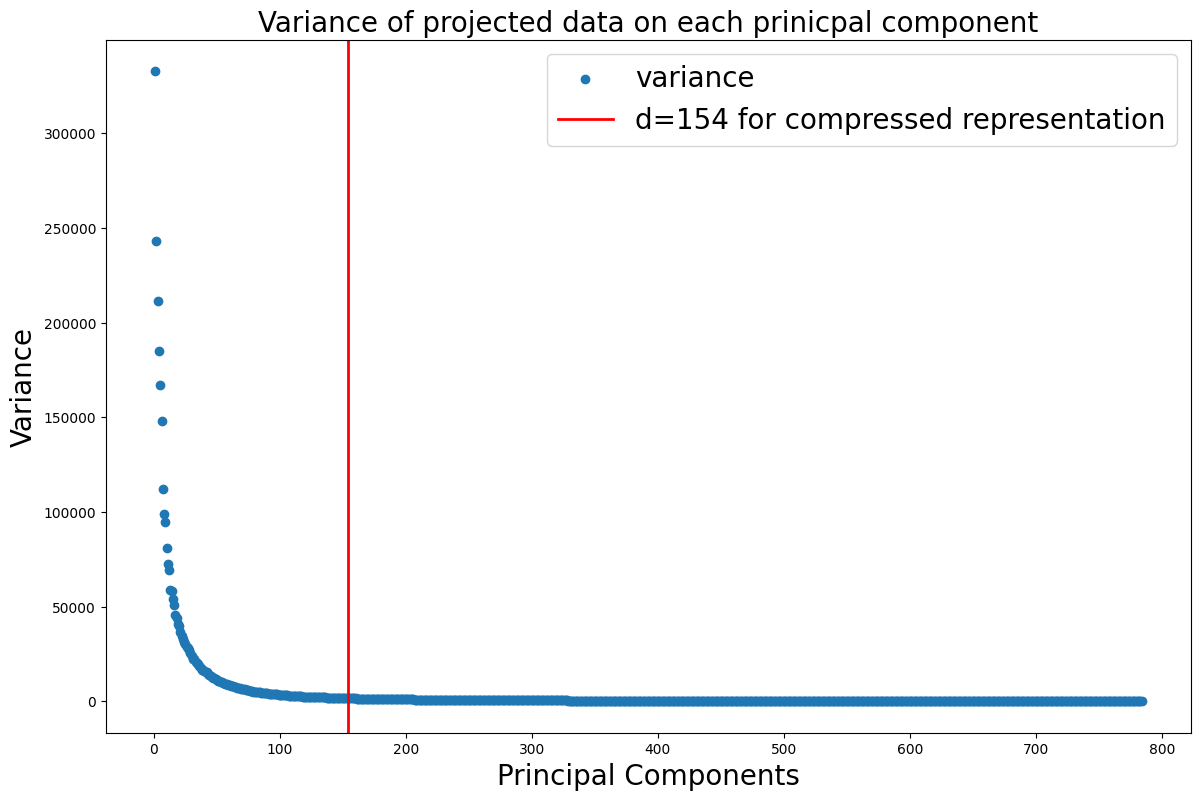

In [26]:
plt.figure(figsize=(14,9))
plt.scatter(1+np.arange(d),pc_variance,label='variance')
plt.axvline(x=k,color='red',lw=2,label='d=154 for compressed representation')
plt.xlabel("Principal Components",fontsize=20)
plt.ylabel("Variance",fontsize=20)
plt.title("Variance of projected data on each prinicpal component",fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [27]:
k_list=[1,10,50,k]
test_results=[]
num=4
for j in k_list:
  his=[]
  for i in range(num):
    img=test_data[i]
    proj=img@eig_vec[:,:j+1]
    try:
      recon=eig_vec[:,:j+1]@(proj)
    except ValueError:
      recon=proj*eig_vec[:,:j+1]
    his.append(recon.reshape((28,28)))
  test_results.append(his)

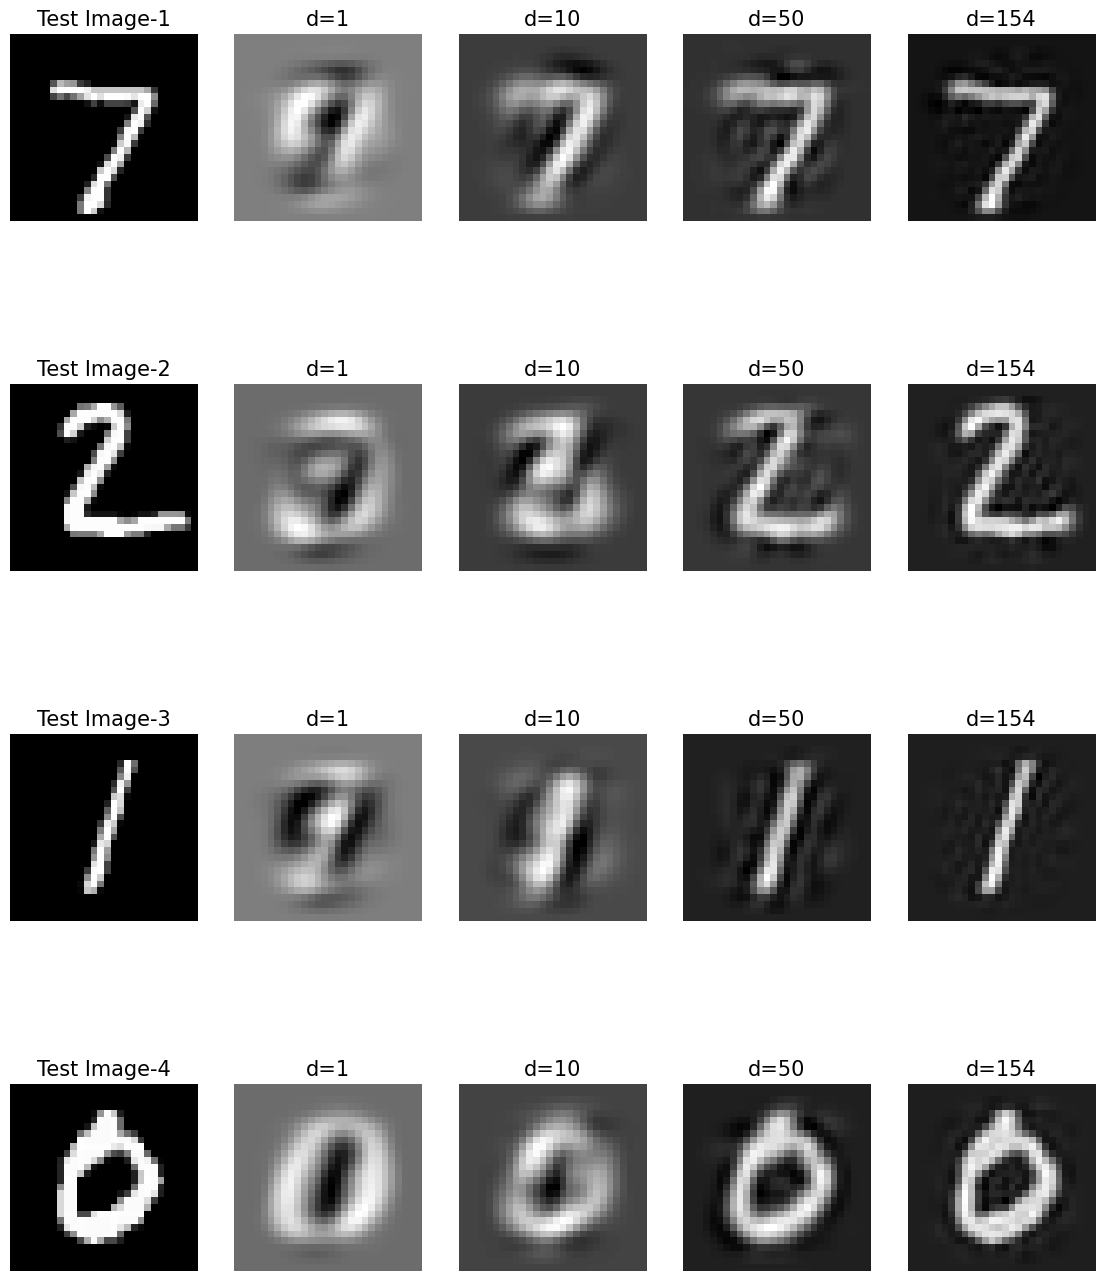

In [28]:
fig=plt.figure(figsize=(14,14))
sub_figs=fig.subfigures(4,1)
for i,sub in enumerate(sub_figs.flat):
  axs=sub.subplots(1,5)
  for j,ax in enumerate(axs):  
    ax.axis('off')  
    if j==0:
      ax.imshow(test_data[i].reshape((28,28)),cmap='gray')
      ax.set_title(f"Test Image-{i+1}",fontsize=15)
    else:
      ax.imshow(test_results[j-1][i],cmap='gray')
      ax.set_title(f"d={k_list[j-1]}",fontsize=15)

In [31]:
def polynomial_kernel(x,y,d):

  return (1+np.dot(x,y))**d

def rbf(x,y,sigma):

  return np.exp(-0.5*np.dot(x-y,x-y)/(sigma**2))

In [32]:
label=mnist['train']['label']
label[:10]

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]

In [41]:
size=1000
K_pol=np.zeros((3,size,size))
K_rbf=np.zeros((5,size,size))
d_list=[2,3,4]
sig_list=[1,1e3,1e4,1e5,1e6]
for i in range(size):
  for j in range(size):
    for _,m in enumerate(d_list):
      K_pol[_,i,j]=polynomial_kernel(dataset[i],dataset[j],m)
    for _,m in enumerate(sig_list):
      K_rbf[_,i,j]=rbf(dataset[i],dataset[j],m)


In [ ]:
for i in range(K_pol.shape[0]):
  temp=K_pol[i,:,:]
  temp_sum=temp.sum()
  for j in range(size):
    j_sum=temp[j,:].sum()
    for k in range(size):
      K_pol[i,j,k]=temp[j,k]-(1/size)*(j_sum+temp[k,:].sum())+(1/(size**2))*temp_sum

for i in range(K_rbf.shape[0]):
  temp=K_rbf[i,:,:]
  temp_sum=temp.sum()
  for j in range(size):
    j_sum=temp[j,:].sum()
    for k in range(size):
      K_rbf[i,j,k]=temp[j,k]-(1/size)*(j_sum+temp[k,:].sum())+(1/(size**2))*temp_sum

In [45]:
eig_val_pol=np.zeros((3,size))
eig_vec_pol=np.zeros((3,size,size))
for i in range(K_pol.shape[0]):
  eig_val,eig_vec=np.linalg.eigh(K_pol[i,:,:])
  eig_val=np.flip(eig_val)
  eig_vec=np.flip(eig_vec,axis=1)
  for j in range(size):
    if eig_val[j]!=0:
      eig_vec[:,j]=eig_vec[:,j]/(eig_val[j]**0.5)
  eig_val_pol[i,:]=eig_val
  eig_vec_pol[i,:,:]=eig_vec

<ipython-input-45-6370f95d6ed0>:9: RuntimeWarning: invalid value encountered in double_scalars
  eig_vec[:,j]=eig_vec[:,j]/(eig_val[j]**0.5)


In [46]:
eig_val_rbf=np.zeros((5,size))
eig_vec_rbf=np.zeros((5,size,size))
for i in range(K_rbf.shape[0]):
  eig_val,eig_vec=np.linalg.eigh(K_rbf[i,:,:])
  eig_val=np.flip(eig_val)
  eig_vec=np.flip(eig_vec,axis=1)
  for j in range(size):
    if eig_val[j]!=0:
      eig_vec[:,j]=eig_vec[:,j]/(eig_val[j]**0.5)
  eig_val_rbf[i,:]=eig_val
  eig_vec_rbf[i,:,:]=eig_vec

<ipython-input-46-5f1ac1044edb>:9: RuntimeWarning: invalid value encountered in double_scalars
  eig_vec[:,j]=eig_vec[:,j]/(eig_val[j]**0.5)


In [47]:
pol_results=np.zeros((3,size,2))
for i in range(K_pol.shape[0]):
  for j in range(size):
    img=dataset[j]
    proj=K_pol[i,j,:]@eig_vec_pol[i,:,:2]
    pol_results[i,j,:]=proj
   

In [48]:
rbf_results=np.zeros((5,size,2))
for i in range(K_rbf.shape[0]):
  for j in range(size):
    img=dataset[j]
    proj=K_rbf[i,j,:]@eig_vec_rbf[i,:,:2]
    rbf_results[i,j,:]=proj


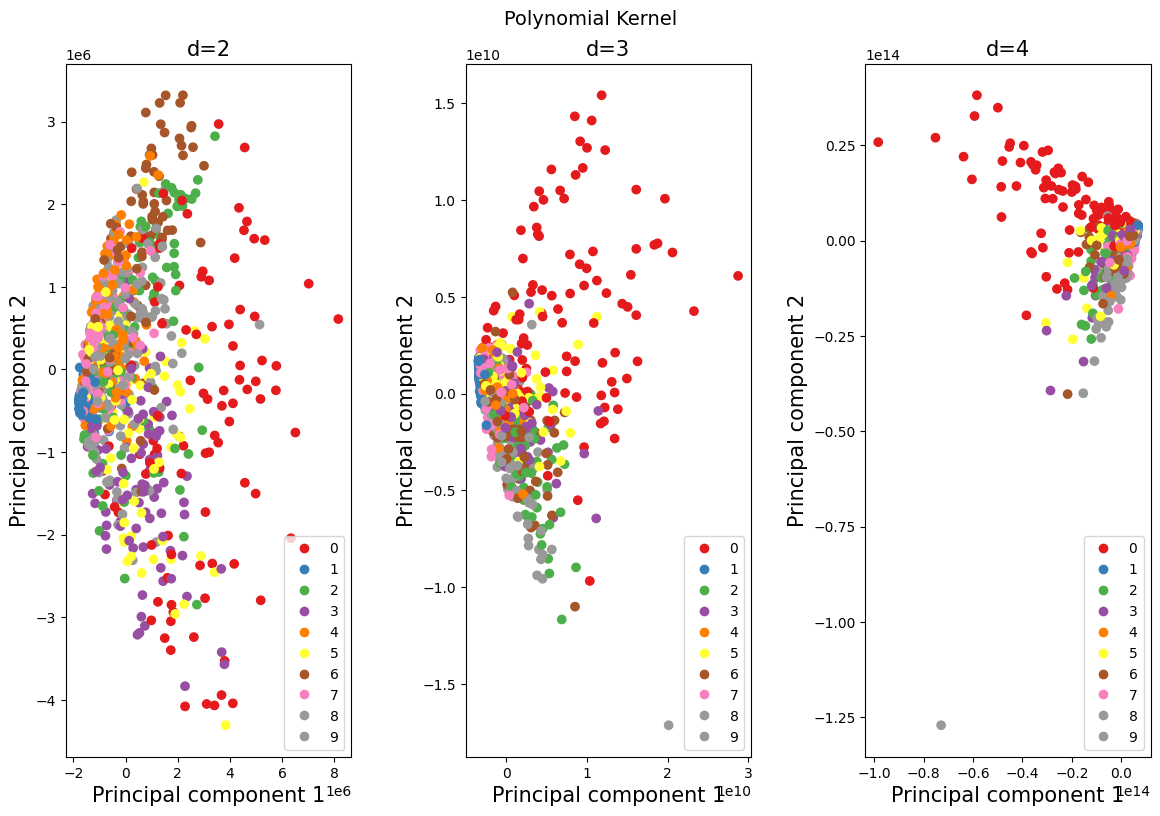

In [49]:
label=mnist['train']['label']
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.4)
for i,ax in enumerate(axs):
  plot=ax.scatter(pol_results[i,:,0],pol_results[i,:,1],c=label[:size],cmap='Set1')
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('Principal component 1',fontsize=15)
  ax.set_ylabel('Principal component 2',fontsize=15)
  ax.legend(*plot.legend_elements(),loc='lower right')

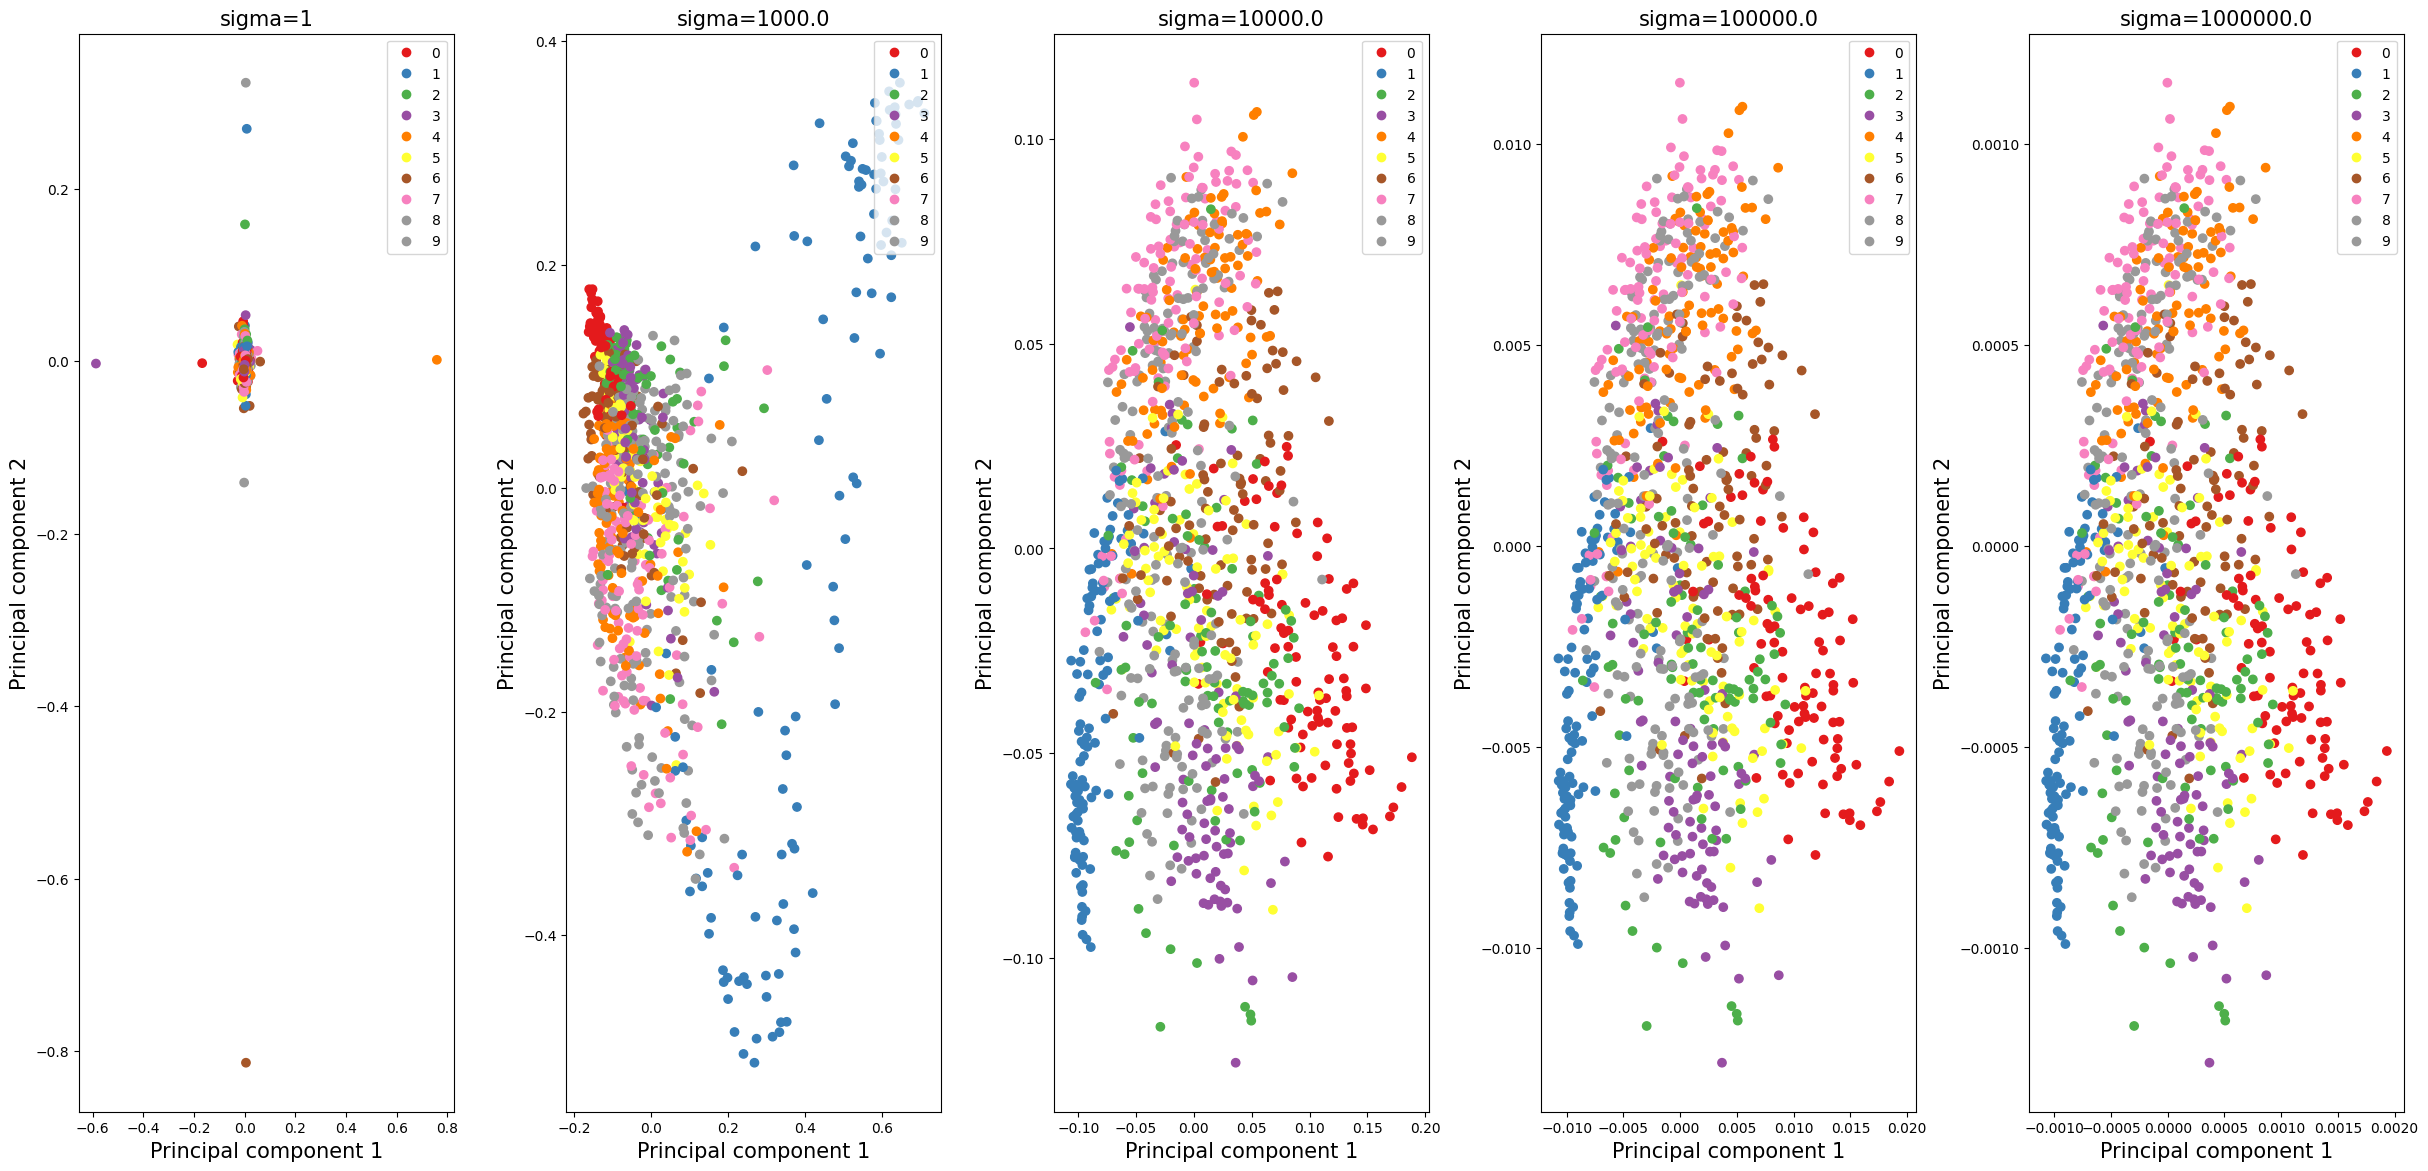

In [52]:
fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(30,14))
plt.title('Gaussian Kernel',fontsize=15,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.1)
for i,ax in enumerate(axs):
  plot=ax.scatter(rbf_results[i,:,0],rbf_results[i,:,1],c=label[:size],cmap='Set1')
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlabel('Principal component 1',fontsize=15)
  ax.set_ylabel('Principal component 2',fontsize=15)
  ax.legend(*plot.legend_elements(),loc='upper right')

In [53]:
pol_d=[]
rbf_d=[]
for i in range(eig_val_pol.shape[0]):
  eig_val=eig_val_pol[i,:]
  sum=0
  total_sum=np.sum(eig_val)
  for j in range(len(eig_val)):
    sum+=eig_val[j]
    ratio=sum/total_sum
    if ratio>=0.95: 
      k=j+1
      break 
  pol_d.append(k)

for i in range(eig_val_rbf.shape[0]):
  eig_val=eig_val_rbf[i,:]
  sum=0
  total_sum=np.sum(eig_val)
  for j in range(len(eig_val)):
    sum+=eig_val[j]
    ratio=sum/total_sum
    if ratio>=0.95: 
      k=j+1
      break 
  rbf_d.append(k)

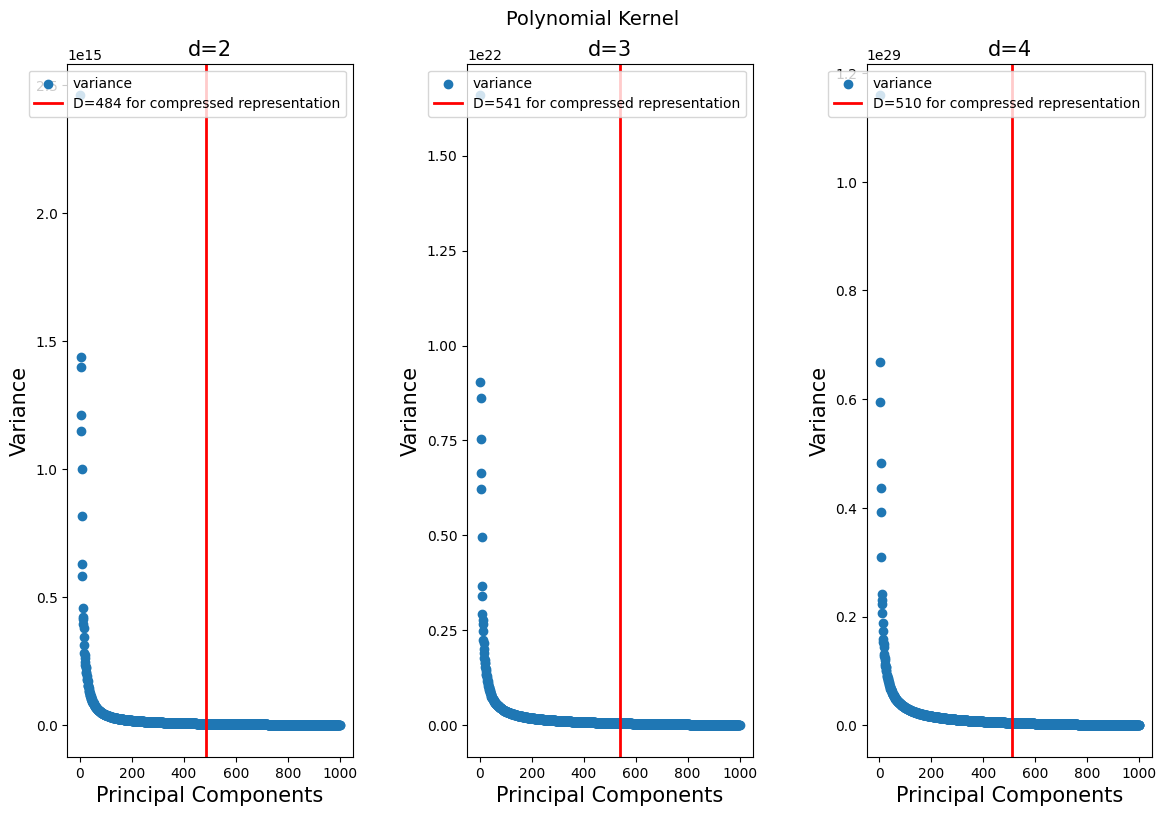

In [54]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.4)
for i,ax in enumerate(axs):
  plot=ax.scatter(1+np.arange(size),eig_val_pol[i,:],label='variance')
  ax.axvline(x=pol_d[i],color='red',lw=2,label=f'D={pol_d[i]} for compressed representation')
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('Principal Components',fontsize=15)
  ax.set_ylabel('Variance',fontsize=15)
  ax.legend()

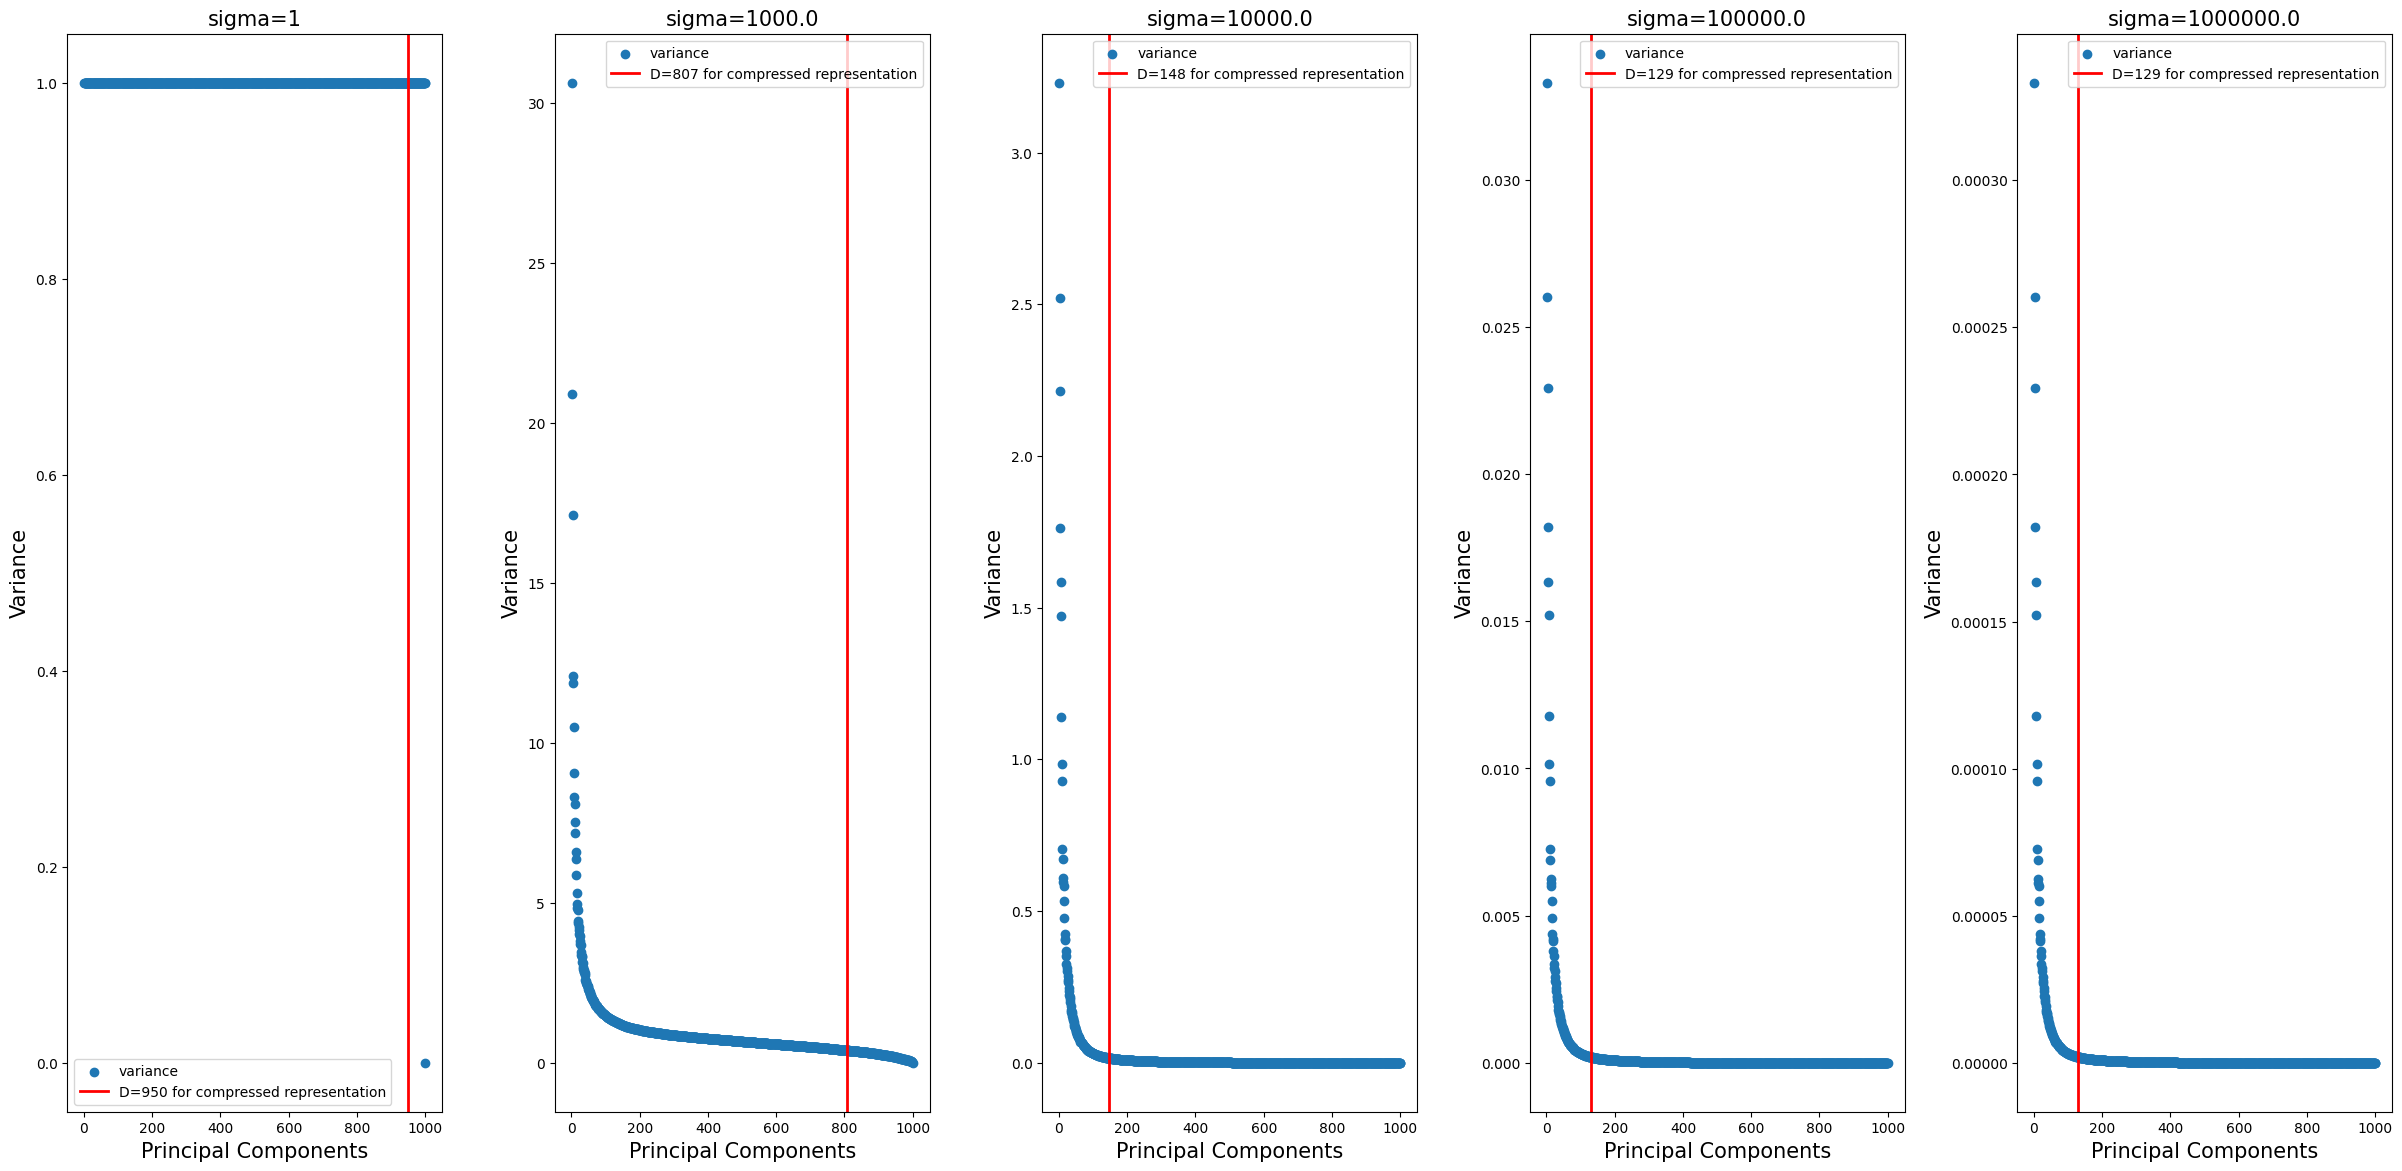

In [55]:
fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(30,14))
plt.subplots_adjust(wspace=0.3)
for i,ax in enumerate(axs.flat):
  ax.scatter(1+np.arange(size),eig_val_rbf[i,:],label='variance')
  ax.axvline(x=rbf_d[i],color='red',lw=2,label=f'D={rbf_d[i]} for compressed representation')
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlabel('Principal Components',fontsize=15)
  ax.set_ylabel('Variance',fontsize=15)
  ax.legend()

In [7]:
import pandas as pd

In [8]:
df=pd.read_csv('/content/cm_dataset_2.csv',header=None)
data=df.to_numpy()

In [ ]:
k=2
num=5
mean=np.zeros((num,k,2))
size=data.shape[0]
Z=np.random.randint(0,k,(num,size))
iter=100

In [ ]:
def cluster_assignment(i):
  error=0
  for j in range(size):
    idx=int(Z[i,j])
    error+=np.linalg.norm(data[j,:]-mean[i,idx,:])**2
    distance=[np.linalg.norm(data[j,:]-mu) for mu in mean[i,:,:]]
    closest=np.argmin(distance)
    Z[i,j]=closest
  return np.array(error)

In [ ]:
def mean_assignment(i):
  for j in range(k):
    current=np.where(Z[i,:]==j)[0]
    mean[i,j,:]=data[current,:].mean(axis=0)

In [ ]:
error_his=np.zeros((iter,num))
for i in range(iter):
  temp=Z.copy()
  for j in range(num):
    mean_assignment(j)
    error=cluster_assignment(j)
    error_his[i,j]=error
  if np.sum(Z-temp)==0:
    break

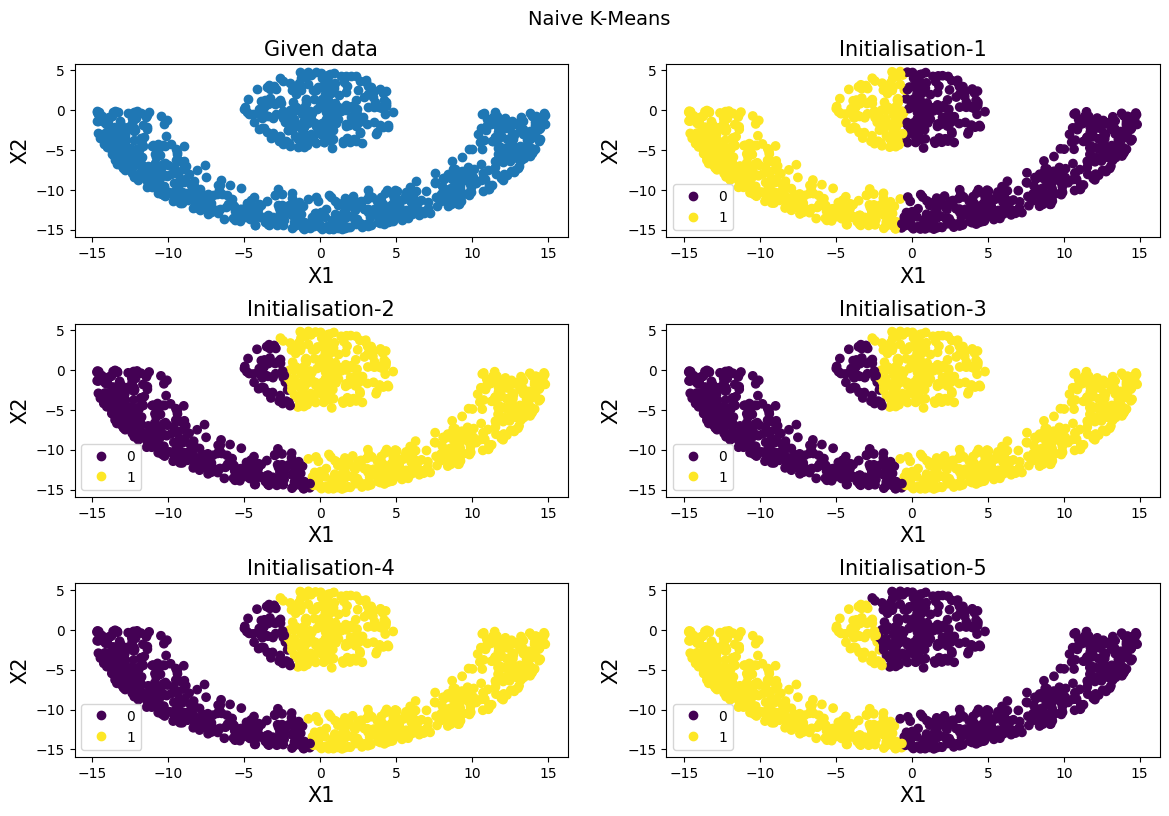

In [ ]:
fig,axs=plt.subplots(nrows=3,ncols=2,figsize=(14,9))
fig.suptitle('Naive K-Means',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.2,hspace=0.5)
for i,ax in enumerate(axs.flat):
  if i==0:
    ax.scatter(data[:,0],data[:,1])
    ax.set_title("Given data",fontsize=15)
    ax.set_xlabel('X1',fontsize=15)
    ax.set_ylabel('X2',fontsize=15)
  else:
    plot=ax.scatter(data[:,0],data[:,1],c=Z[i-1,:])
    ax.set_title(f'Initialisation-{i}',fontsize=15)
    ax.set_xlabel('X1',fontsize=15)
    ax.set_ylabel('X2',fontsize=15)
    ax.legend(*plot.legend_elements())

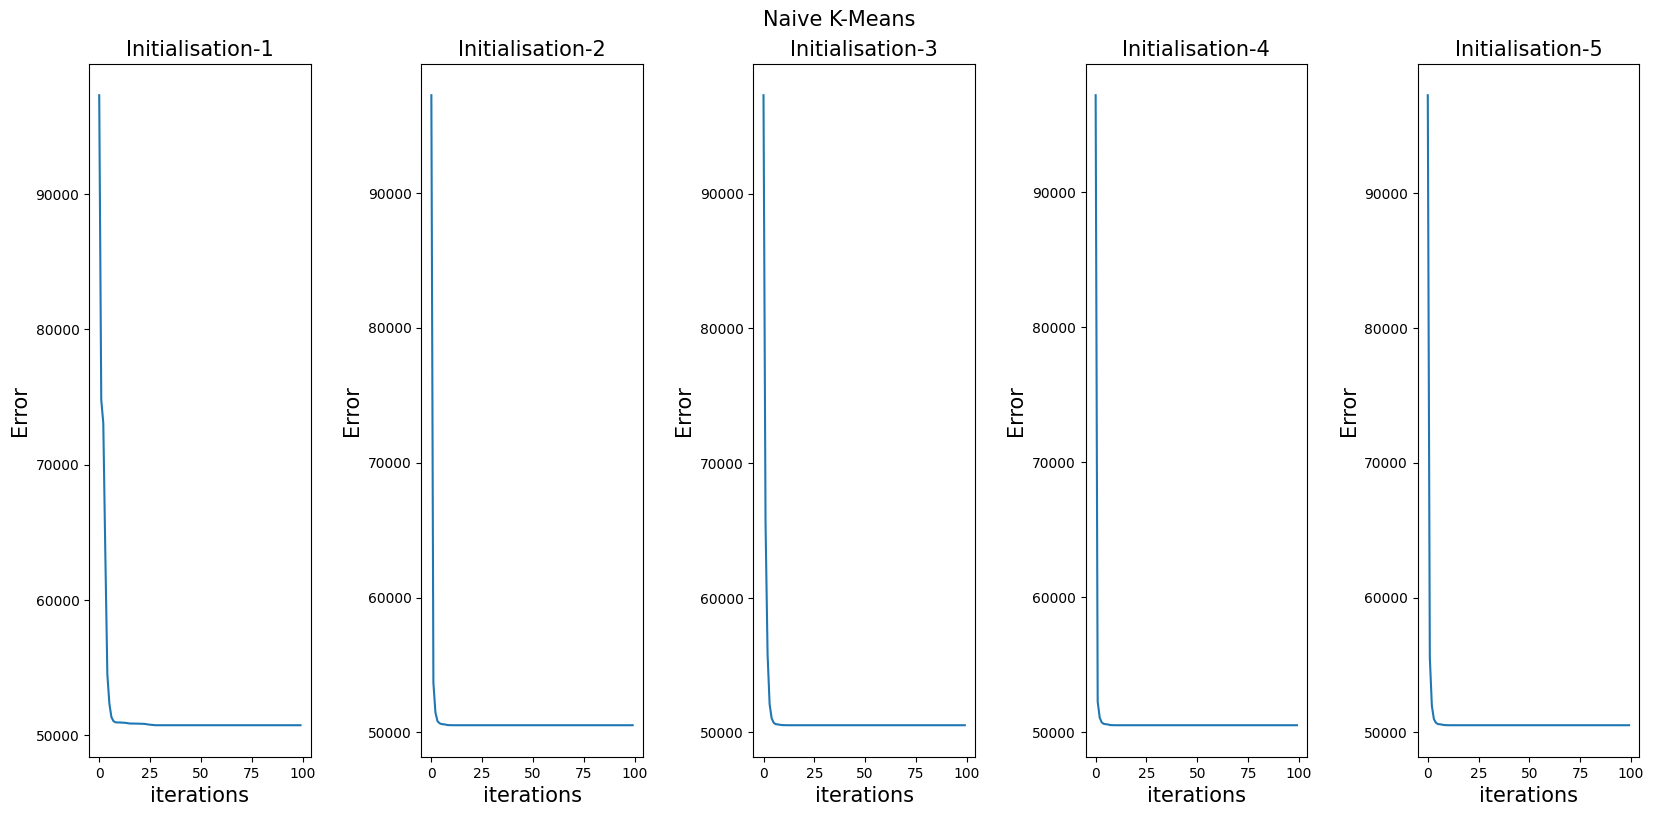

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(20,9))
fig.suptitle('Naive K-Means',fontsize=15,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.5)
for i,ax in enumerate(axs.flat):
  ax.plot(np.arange(iter),error_his[:,i])
  ax.set_title(f'Initialisation-{i+1}',fontsize=15)
  ax.set_xlabel('iterations',fontsize=15)
  ax.set_ylabel('Error',fontsize=15)

In [ ]:
k=2
mean=np.zeros((1,k,2))
size=data.shape[0]
Z=np.random.randint(0,k,(1,size))
iter=100
for i in range(iter):
  temp=Z.copy()
  mean_assignment(0)
  error=cluster_assignment(0)
  if np.sum(Z-temp)==0:
    break
mean_2=mean
Z_2=Z

In [ ]:
k=3
mean=np.zeros((1,k,2))
size=data.shape[0]
Z=np.random.randint(0,k,(1,size))
iter=100
for i in range(iter):
  temp=Z.copy()
  mean_assignment(0)
  error=cluster_assignment(0)
  if np.sum(Z-temp)==0:
    break
mean_3=mean
Z_3=Z

In [ ]:
k=4
mean=np.zeros((1,k,2))
size=data.shape[0]
Z=np.random.randint(0,k,(1,size))
iter=100
for i in range(iter):
  temp=Z.copy()
  mean_assignment(0)
  error=cluster_assignment(0)
  if np.sum(Z-temp)==0:
    break
mean_4=mean
Z_4=Z

In [ ]:
k=5
mean=np.zeros((1,k,2))
size=data.shape[0]
Z=np.random.randint(0,k,(1,size))
iter=100
for i in range(iter):
  temp=Z.copy()
  mean_assignment(0)
  error=cluster_assignment(0)
  if np.sum(Z-temp)==0:
    break
mean_5=mean
Z_5=Z

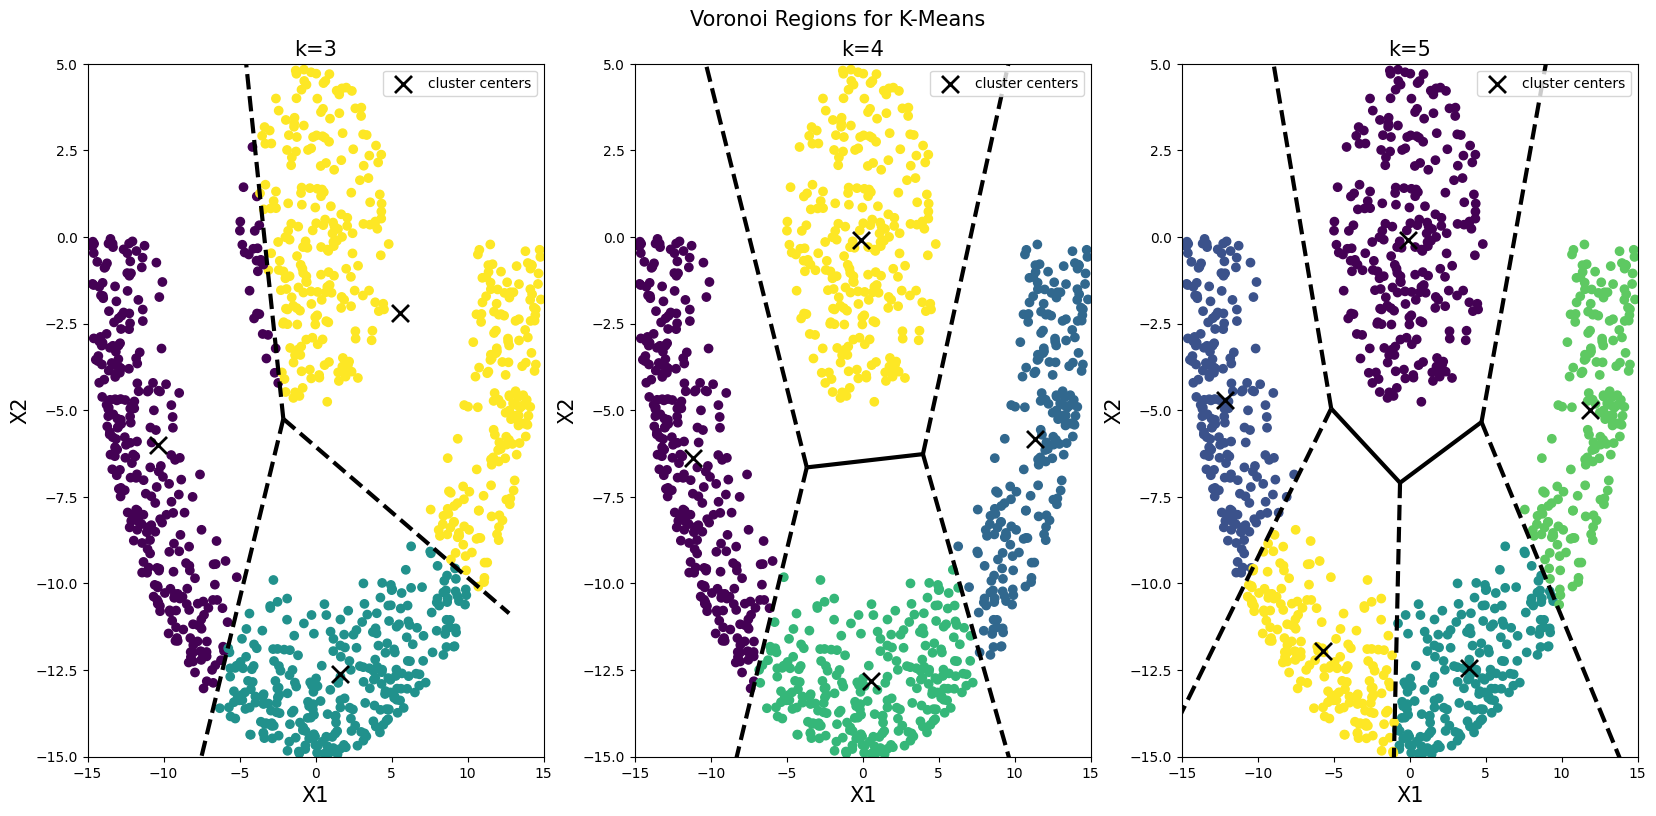

In [ ]:
Z=[Z_3,Z_4,Z_5]
mean=[mean_3,mean_4,mean_5]
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,9))
fig.suptitle('Voronoi Regions for K-Means',fontsize=15,x=0.5,y=0.94)
for i,ax in enumerate(axs.flat):
  mu=mean[i]
  vor=scipy.spatial.Voronoi(mu.squeeze())
  fig1 = voronoi_plot_2d(vor,ax=ax,show_points=False,show_vertices=False,line_width=3)
  idx=Z[i]
  plot=ax.scatter(data[:,0],data[:,1],c=1+idx[0,:])
  ax.scatter(mu.squeeze()[:,0],mu.squeeze()[:,1],color='black',marker='x',s=150,linewidths=2,label='cluster centers')
  ax.set_title(f'k={i+3}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.set_xlim(-15,15)
  ax.set_ylim(-15,5)
  ax.legend(loc='upper right')

  

In [77]:
df=pd.read_csv('/content/cm_dataset_2.csv',header=None)
data=df.to_numpy(dtype=np.float64)

In [73]:
labels=pd.read_csv('labels.csv').to_numpy()[:,1]

In [78]:
size=1000
K_pol=np.zeros((3,size,size))
K_rbf=np.zeros((3,size,size))
d_list=[2,3,4]
sig_list=[10,100,1000]
for i in range(size):
  for j in range(size):
    for _,m in enumerate(d_list):
      K_pol[_,i,j]=polynomial_kernel(data[i,:],data[j,:],m)
    for _,m in enumerate(sig_list):
      K_rbf[_,i,j]=rbf(data[i,:],data[j,:],m)


In [ ]:
for i in range(K_pol.shape[0]):
  temp=K_pol[i,:,:]
  temp_sum=temp.sum()
  for j in range(size):
    j_sum=temp[j,:].sum()
    for k in range(size):
      K_pol[i,j,k]=temp[j,k]-(1/size)*(j_sum+temp[k,:].sum())+(1/(size**2))*temp_sum

for i in range(K_rbf.shape[0]):
  temp=K_rbf[i,:,:]
  temp_sum=temp.sum()
  for j in range(size):
    j_sum=temp[j,:].sum()
    for k in range(size):
      K_rbf[i,j,k]=temp[j,k]-(1/size)*(j_sum+temp[k,:].sum())+(1/(size**2))*temp_sum

In [79]:
eig_vec_pol=np.zeros((3,size,size))
for i in range(K_pol.shape[0]):
  eig_val,eig_vec=np.linalg.eigh(K_pol[i,:,:])
  eig_vec=np.flip(eig_vec,axis=1)
  eig_vec_pol[i,:,:]=eig_vec

In [80]:
eig_vec_rbf=np.zeros((3,size,size))
for i in range(K_rbf.shape[0]):
  eig_val,eig_vec=np.linalg.eigh(K_rbf[i,:,:])
  eig_vec=np.flip(eig_vec,axis=1)
  eig_vec_rbf[i,:,:]=eig_vec

In [94]:
data_new_pol=[]   
for i in range(3):
  temp=np.zeros((size,2))
  for j in range(size):
    data_point=eig_vec_pol[i,j,:2]
    temp[j,:]=data_point/np.linalg.norm(data_point)
  data_new_pol.append(temp)
data_new_pol_un=[]   
for i in range(3):
  temp=np.zeros((size,2))
  for j in range(size):
    data_point=eig_vec_pol[i,j,:2]
    temp[j,:]=data_point
  data_new_pol_un.append(temp)

In [95]:
data_new_rbf=[]   
for i in range(3):
  temp=np.zeros((size,2))
  for j in range(size):
    data_point=eig_vec_rbf[i,j,:2]
    temp[j,:]=data_point/np.linalg.norm(data_point)
  data_new_rbf.append(temp)
data_new_rbf_un=[]   
for i in range(3):
  temp=np.zeros((size,2))
  for j in range(size):
    data_point=eig_vec_rbf[i,j,:2]
    temp[j,:]=data_point
  data_new_rbf_un.append(temp)

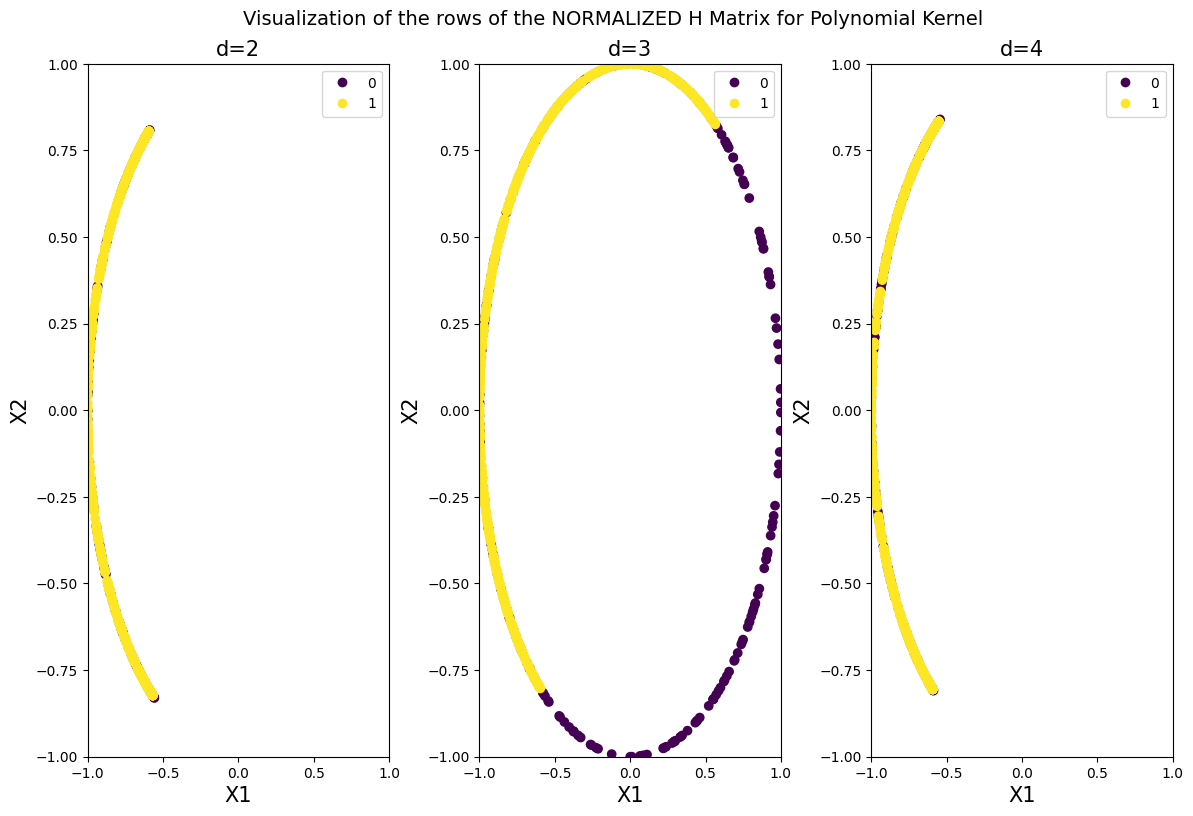

In [108]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Visualization of the rows of the NORMALIZED H Matrix for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):

  plot=ax.scatter(data_new_pol[i][:,0], data_new_pol[i][:,1],c=labels)
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

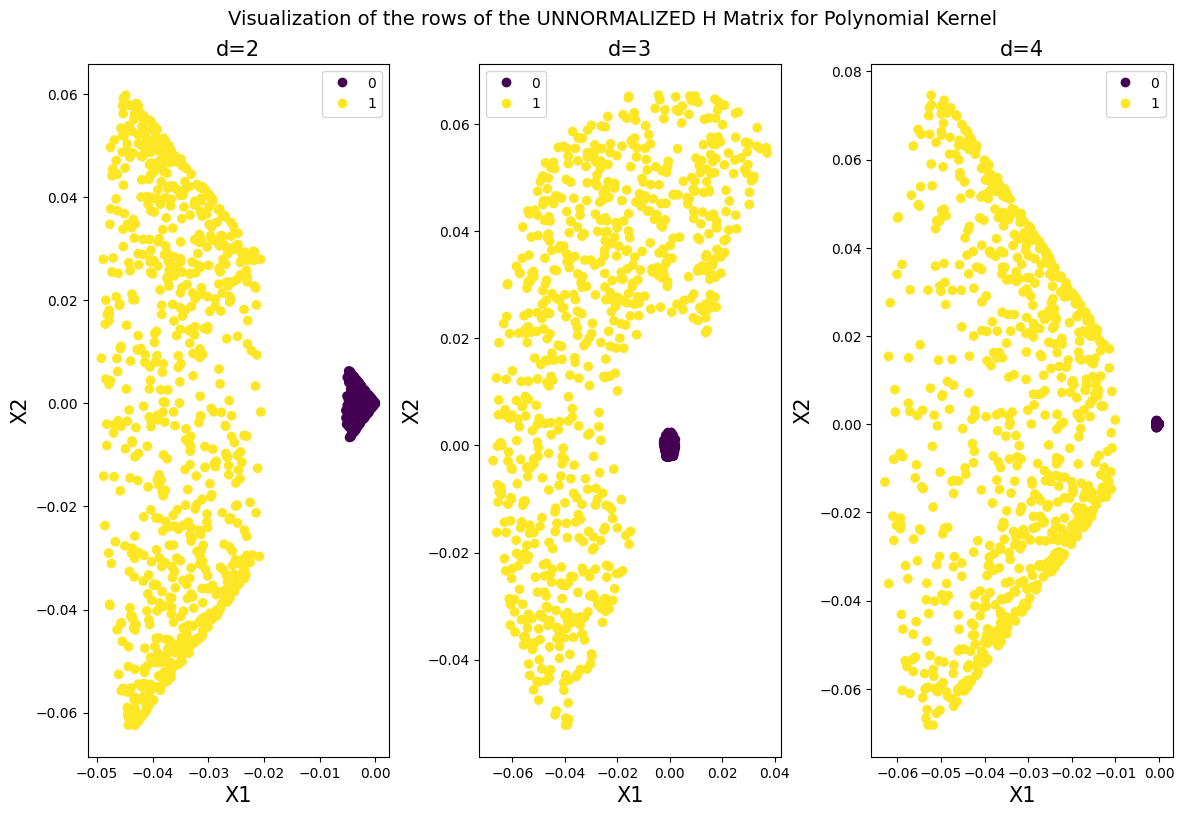

In [101]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Visualization of the rows of the UNNORMALIZED H Matrix for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):

  plot=ax.scatter(data_new_pol_un[i][:,0], data_new_pol_un[i][:,1],c=labels)
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

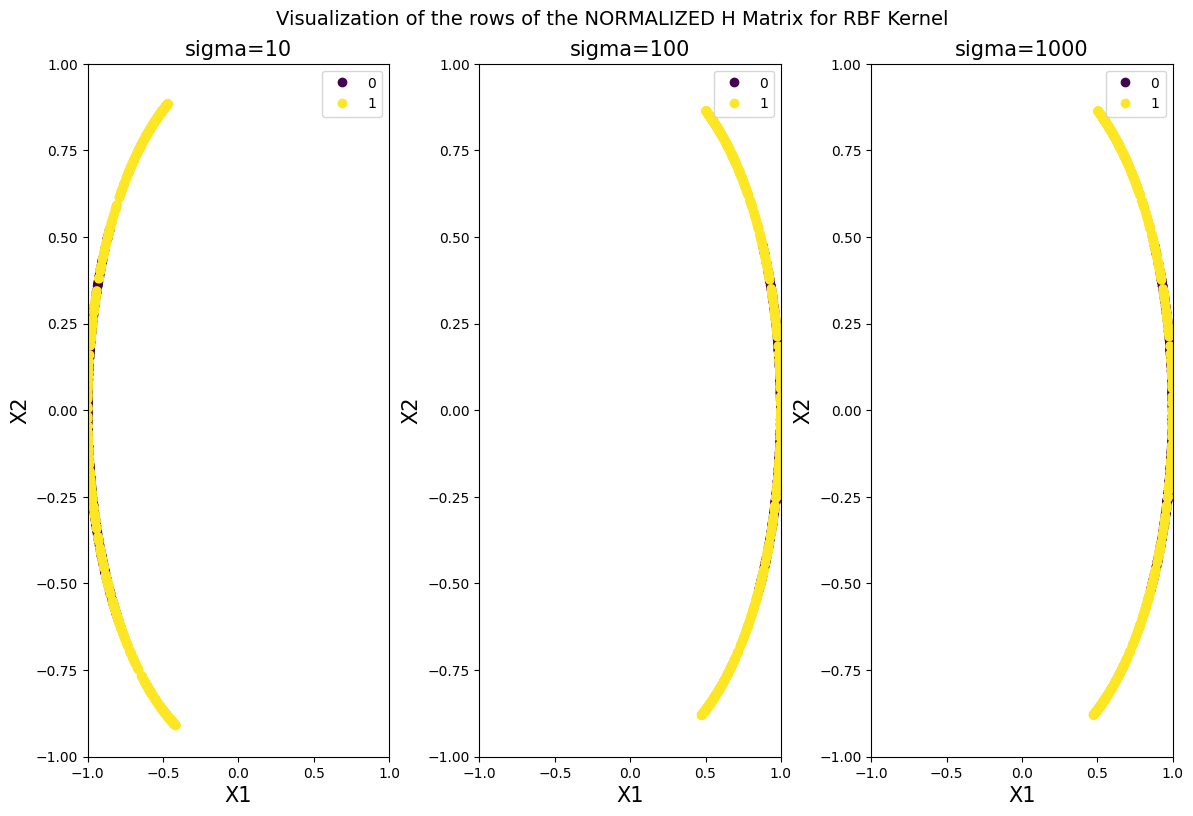

In [116]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Visualization of the rows of the NORMALIZED H Matrix for RBF Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):

  plot=ax.scatter(data_new_rbf[i][:,0], data_new_rbf[i][:,1],c=labels)
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

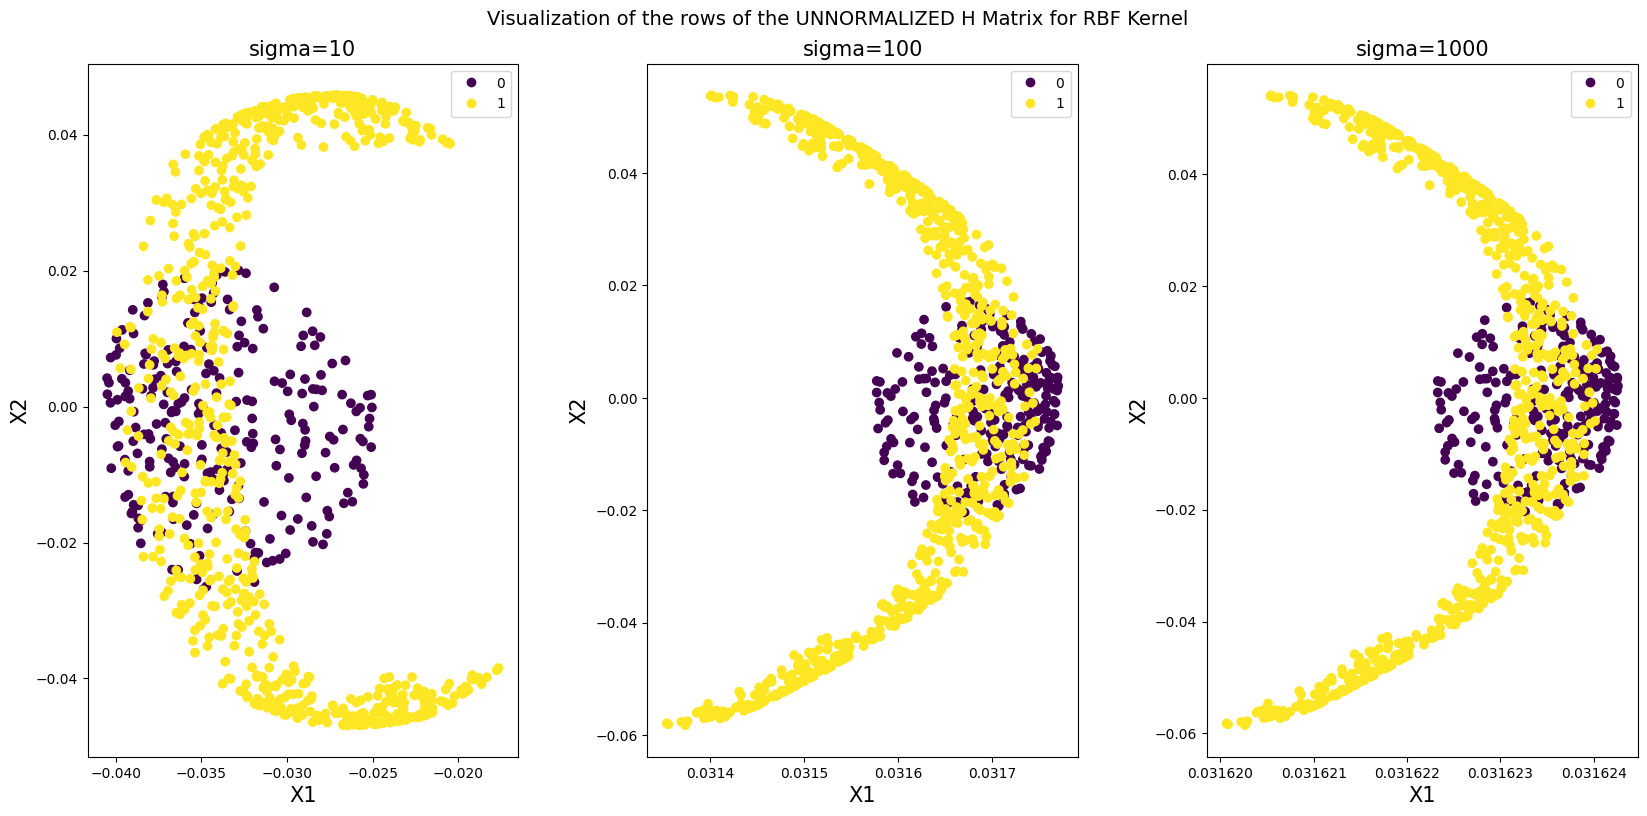

In [115]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,9))
fig.suptitle('Visualization of the rows of the UNNORMALIZED H Matrix for RBF Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):

  plot=ax.scatter(data_new_rbf_un[i][:,0], data_new_rbf_un[i][:,1],c=labels)
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

In [124]:
k=2
num=3
mean=np.zeros((num,k,2))
Z=np.random.randint(0,k,(num,size))
iter=100

In [117]:
def cluster_assignment(i,input):
  for j in range(size):
    idx=int(Z[i,j])
    distance=[np.linalg.norm(input[j,:]-mu) for mu in mean[i,:,:]]
    closest=np.argmin(distance)
    Z[i,j]=closest

In [118]:
def mean_assignment(i,input):
  for j in range(k):
    current=np.where(Z[i,:]==j)[0]
    mean[i,j,:]=input[current,:].mean(axis=0)

In [127]:
mean=np.zeros((num,k,2))
Z=np.random.randint(0,k,(num,size))
for i in range(iter):
  temp=Z.copy()
  for j in range(num):
    mean_assignment(j,data_new_pol[j])
    cluster_assignment(j,data_new_pol[j])    
  if np.sum(Z-temp)==0:
    break

In [128]:
Z_pol=Z.copy()
mean=np.zeros((num,k,2))
Z=np.random.randint(0,k,(num,size))
for i in range(iter):
  temp=Z.copy()
  for j in range(num):
    mean_assignment(j,data_new_rbf[j])
    cluster_assignment(j,data_new_rbf[j])    
  if np.sum(Z-temp)==0:
    break    

Z_rbf=Z.copy()

In [129]:
mean=np.zeros((num,k,2))
Z=np.random.randint(0,k,(num,size))
for i in range(iter):
  temp=Z.copy()
  for j in range(num):
    mean_assignment(j,data_new_pol_un[j])
    cluster_assignment(j,data_new_pol_un[j])    
  if np.sum(Z-temp)==0:
    break

Z_pol_un=Z.copy()
mean=np.zeros((num,k,2))
Z=np.random.randint(0,k,(num,size))
for i in range(iter):
  temp=Z.copy()
  for j in range(num):
    mean_assignment(j,data_new_rbf_un[j])
    cluster_assignment(j,data_new_rbf_un[j])    
  if np.sum(Z-temp)==0:
    break    

Z_rbf_un=Z.copy()


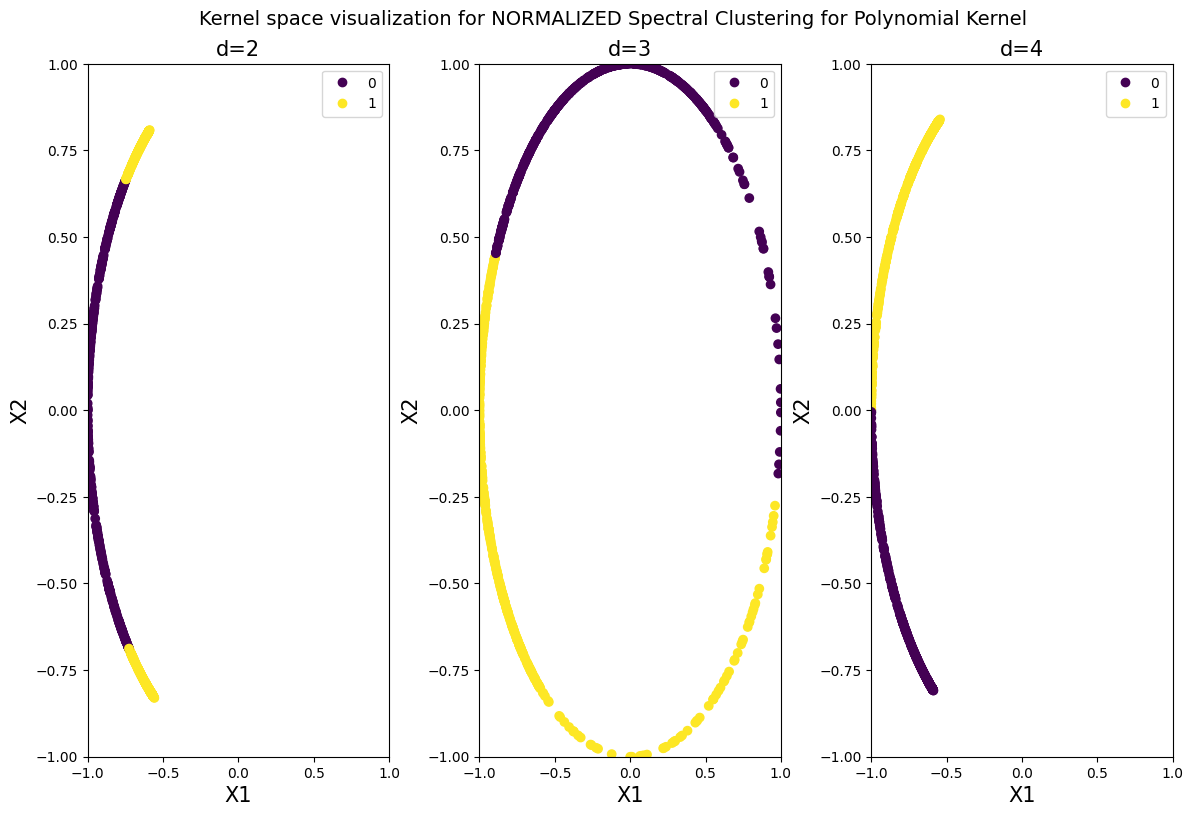

In [130]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Kernel space visualization for NORMALIZED Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data_new_pol[i][:,0], data_new_pol[i][:,1],c=Z_pol[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

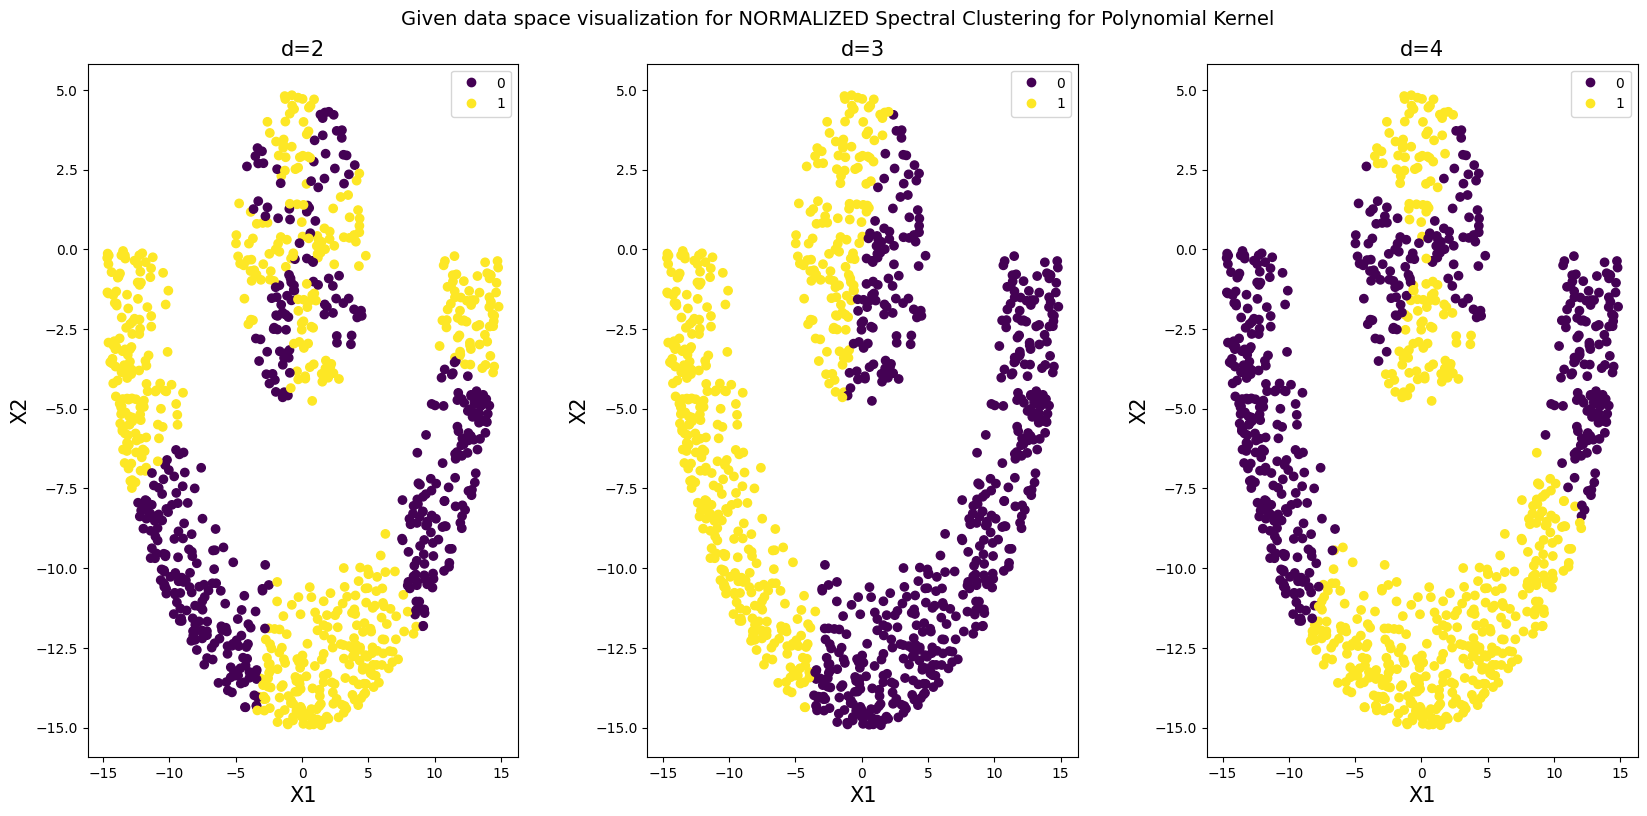

In [136]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,9))
fig.suptitle('Given data space visualization for NORMALIZED Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data[:,0], data[:,1],c=Z_pol[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

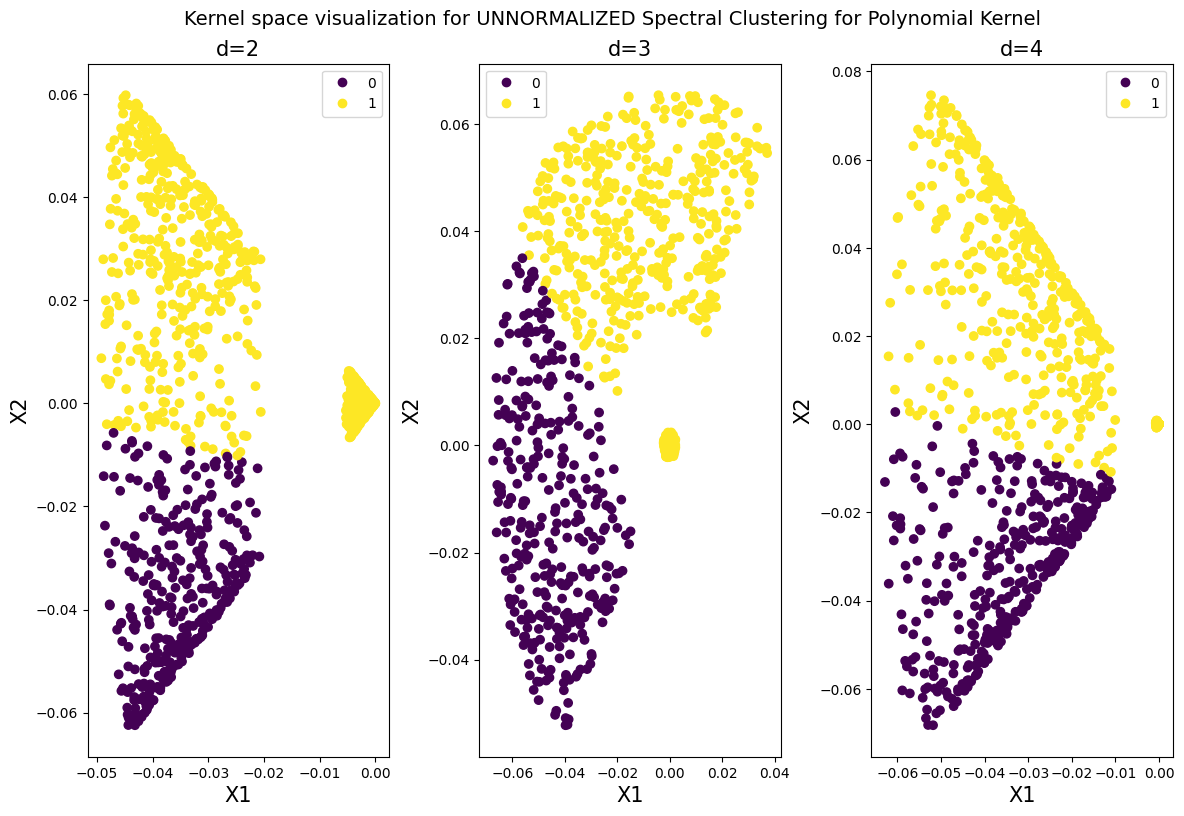

In [138]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Kernel space visualization for UNNORMALIZED Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data_new_pol_un[i][:,0], data_new_pol_un[i][:,1],c=Z_pol_un[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

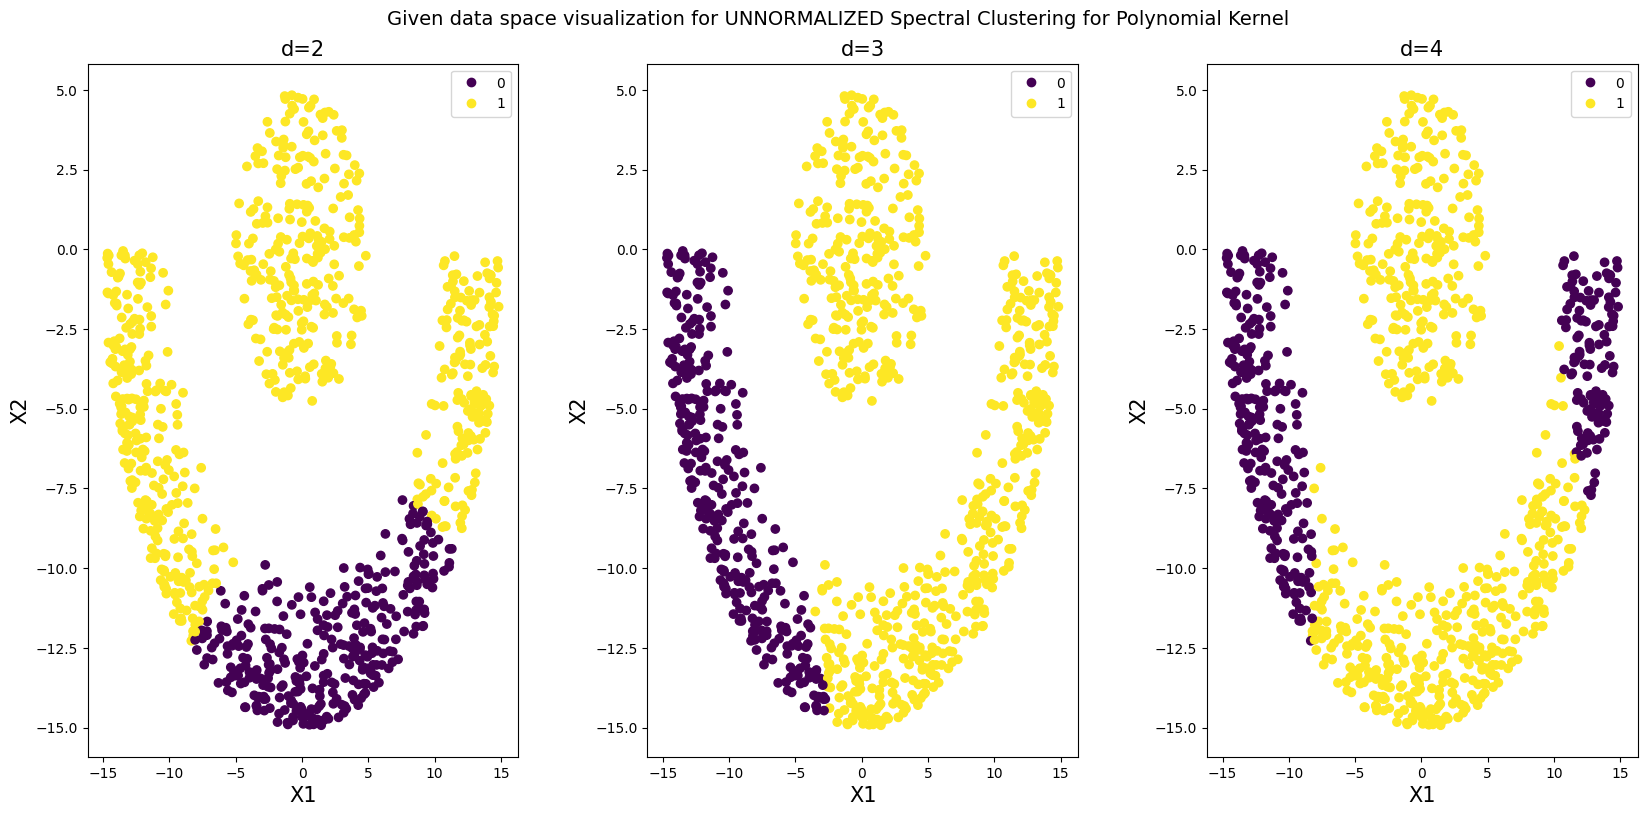

In [139]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,9))
fig.suptitle('Given data space visualization for UNNORMALIZED Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data[:,0], data[:,1],c=Z_pol_un[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

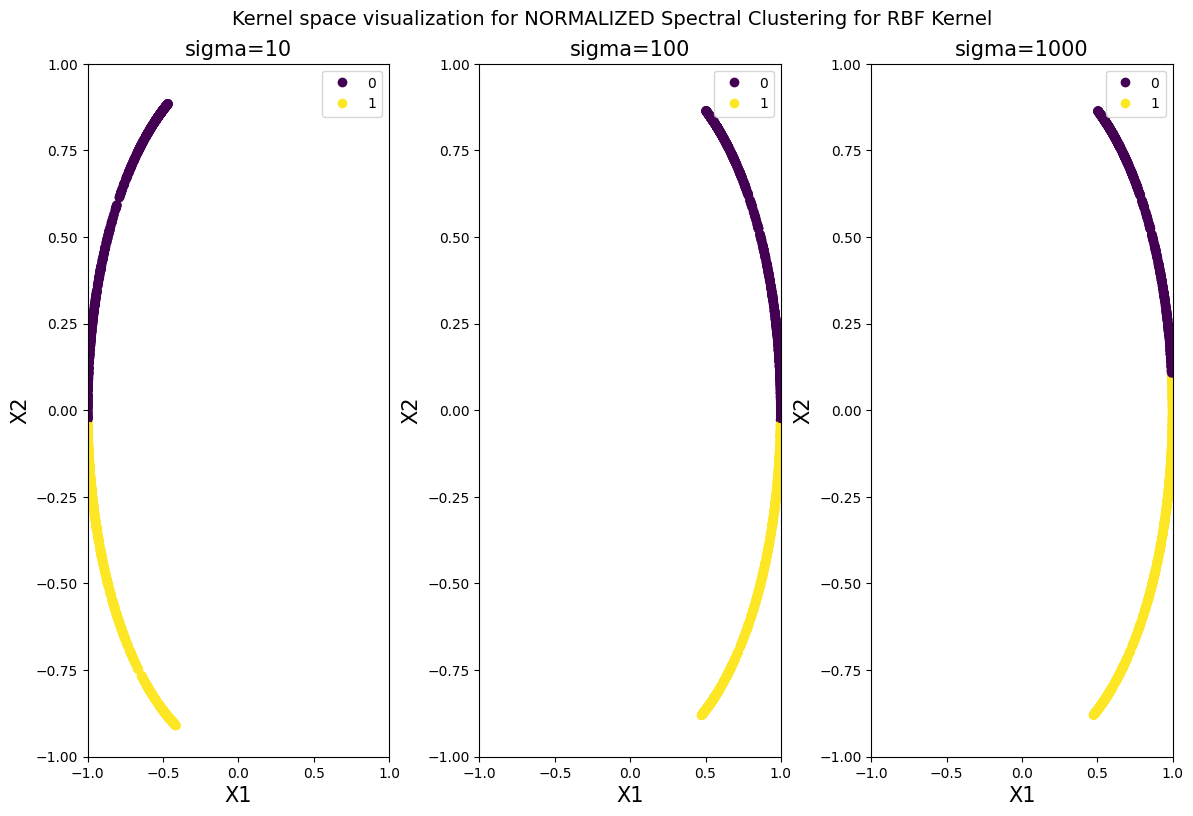

In [140]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Kernel space visualization for NORMALIZED Spectral Clustering for RBF Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data_new_rbf[i][:,0], data_new_rbf[i][:,1],c=Z_rbf[i,:])
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

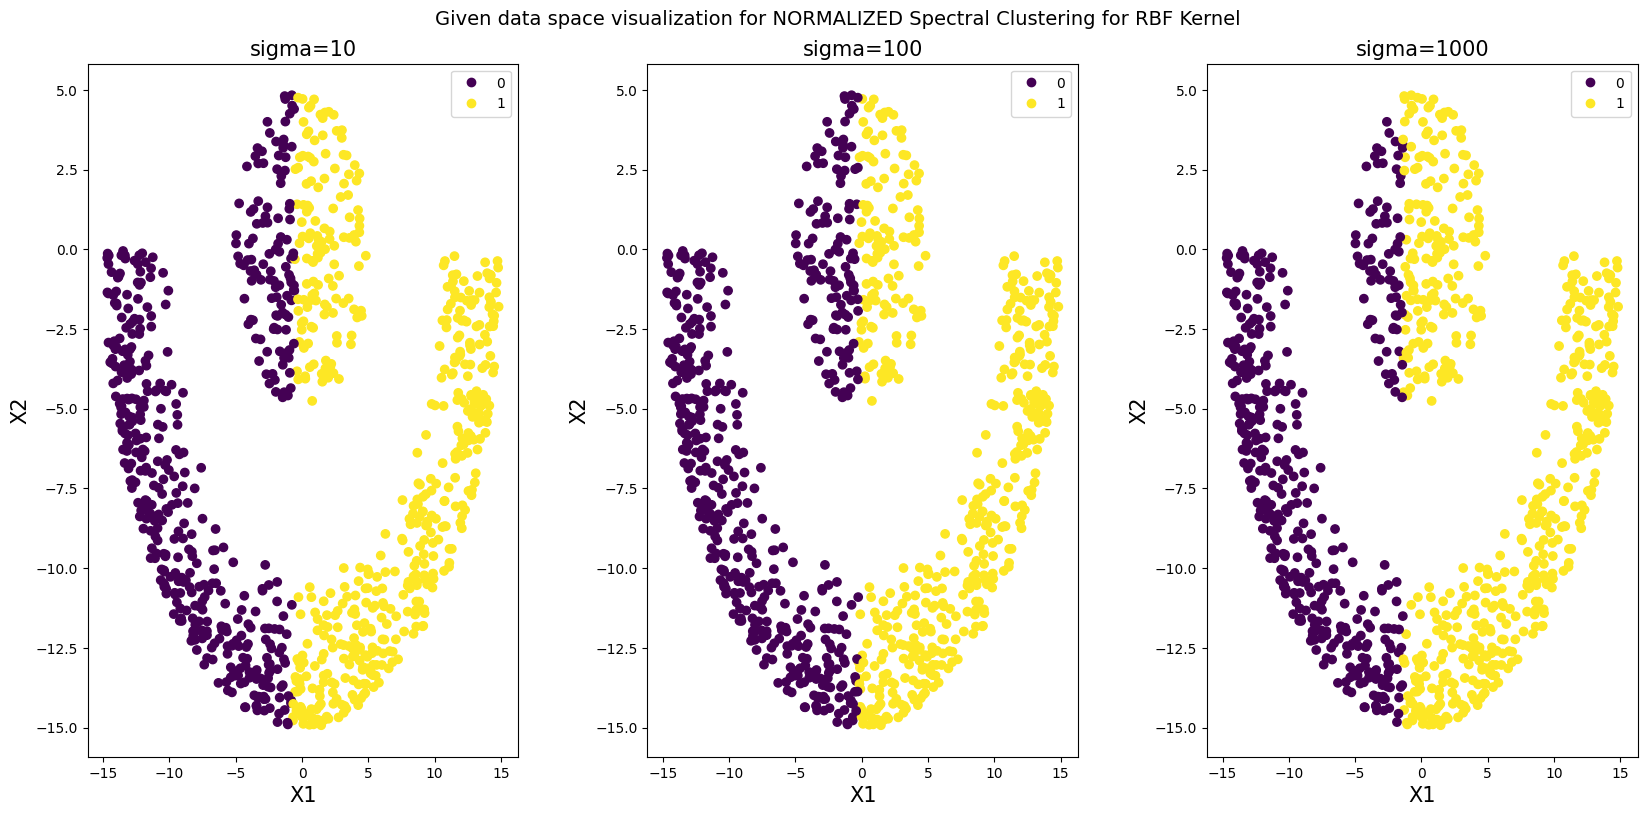

In [141]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,9))
fig.suptitle('Given data space visualization for NORMALIZED Spectral Clustering for RBF Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data[:,0], data[:,1],c=Z_rbf[i,:])
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

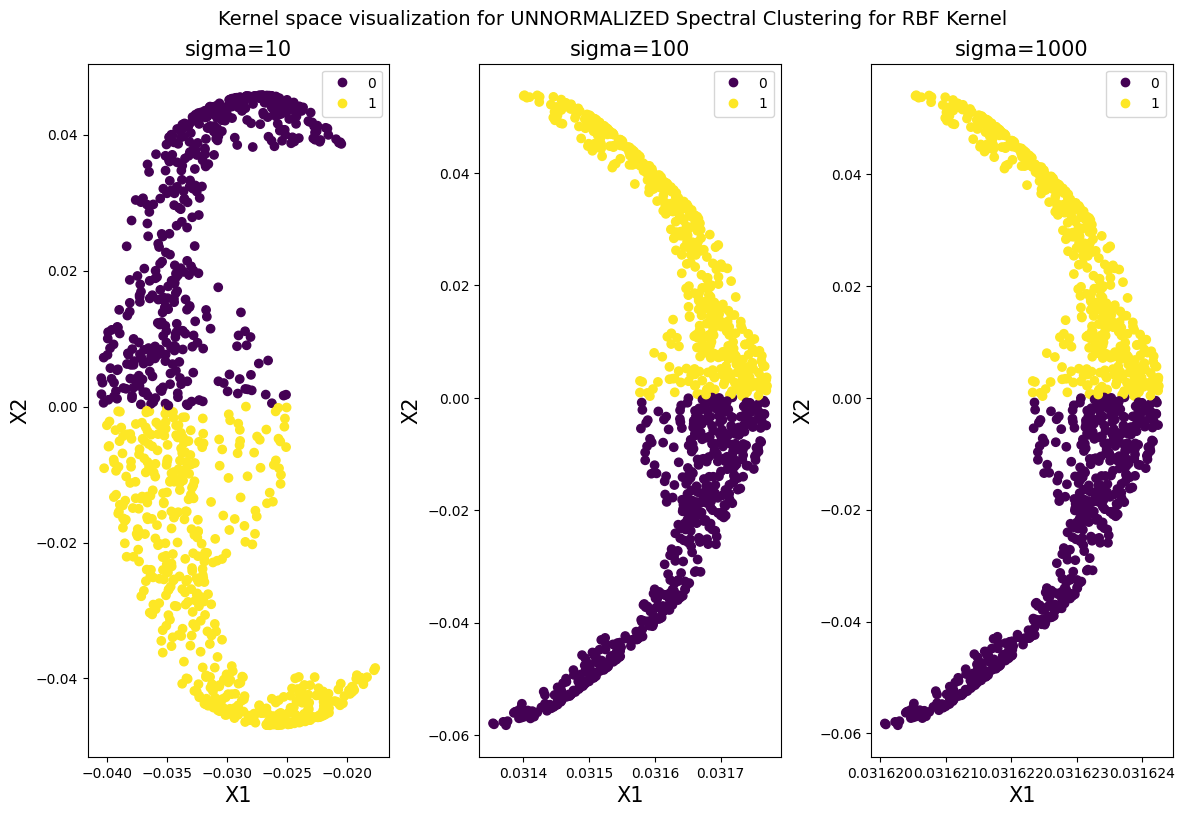

In [142]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Kernel space visualization for UNNORMALIZED Spectral Clustering for RBF Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data_new_rbf_un[i][:,0], data_new_rbf_un[i][:,1],c=Z_rbf_un[i,:])
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

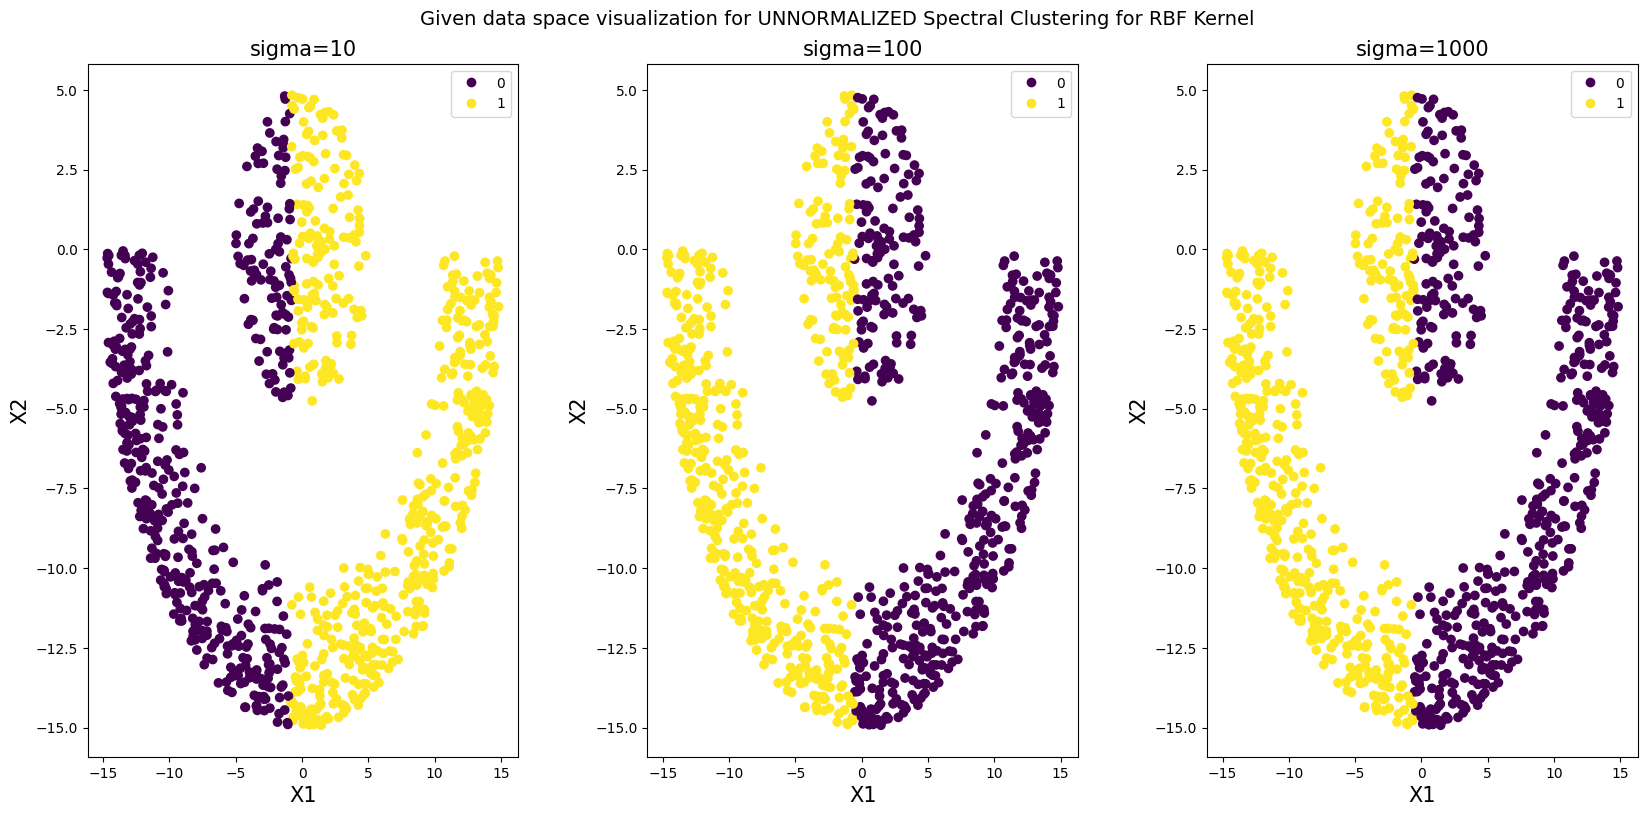

In [143]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,9))
fig.suptitle('Given data space visualization for UNNORMALIZED Spectral Clustering for RBF Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data[:,0], data[:,1],c=Z_rbf_un[i,:])
  ax.set_title(f'sigma={sig_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

In [146]:
initial=np.array([[0.025,0],[-0.05,0]])
mean=np.zeros((num,k,2))
for i in range(num):
  mean[i,:,:]=initial
Z=np.random.randint(0,k,(num,size))
for i in range(iter):
  temp=Z.copy()
  for j in range(num):
    cluster_assignment(j,data_new_pol_un[j]) 
    mean_assignment(j,data_new_pol_un[j])       
  if np.sum(Z-temp)==0:
    break

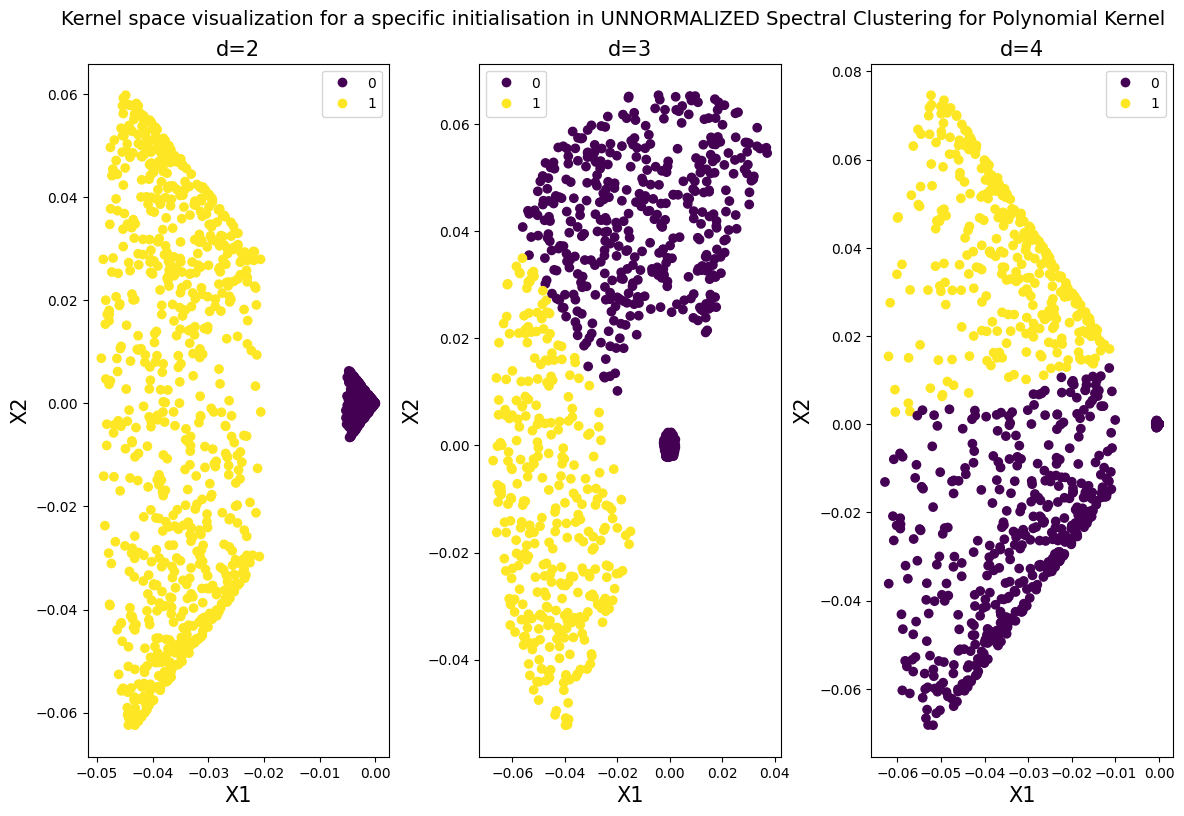

In [147]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Kernel space visualization for a specific initialisation in UNNORMALIZED Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data_new_pol_un[i][:,0], data_new_pol_un[i][:,1],c=Z[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

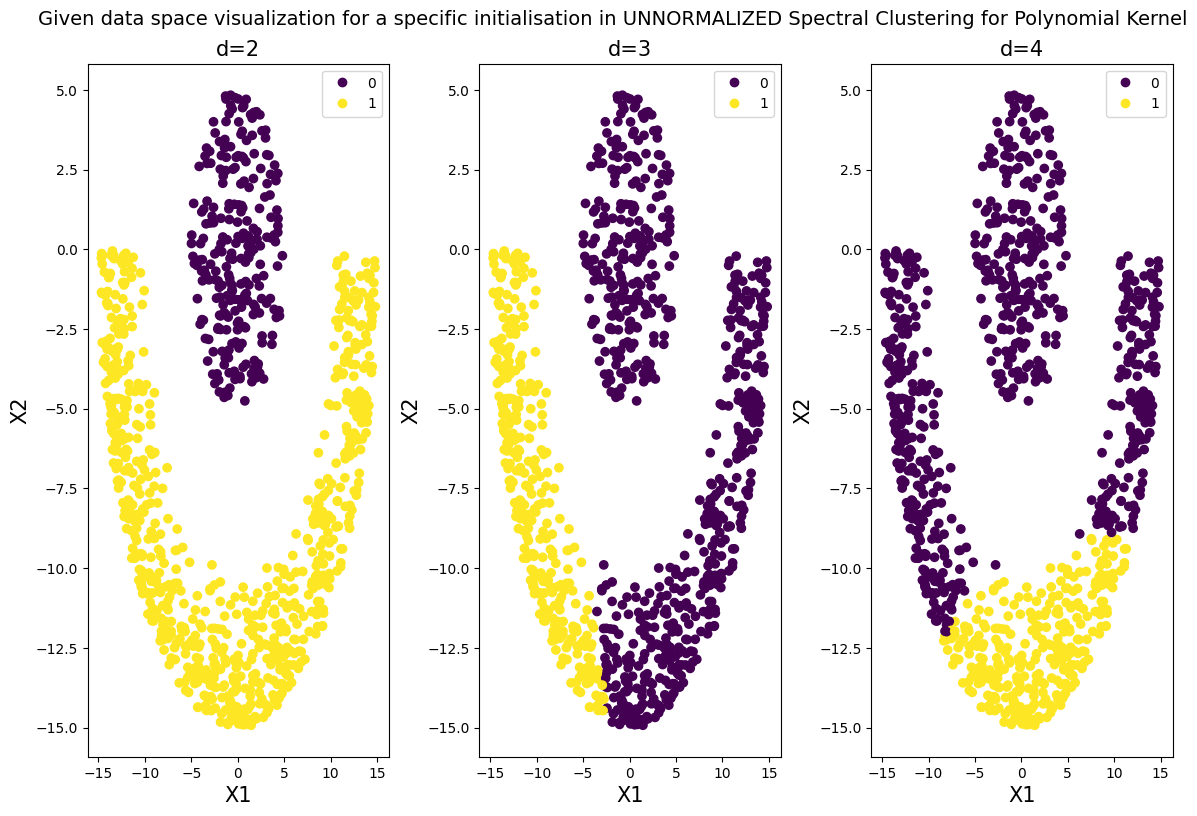

In [149]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Given data space visualization for a specific initialisation in UNNORMALIZED Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data[:,0], data[:,1],c=Z[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

In [150]:
mean=np.zeros((num,k,2))
Z=np.random.randint(0,k,(num,size))
for i in range(size):
  for j in range(num):
    Z[j,i]=np.argmax(data_new_pol_un[j][i,:])
for i in range(iter):
  temp=Z.copy()
  for j in range(num):
    mean_assignment(j,data_new_pol_un[j])   
    cluster_assignment(j,data_new_pol_un[j])         
  if np.sum(Z-temp)==0:
    break

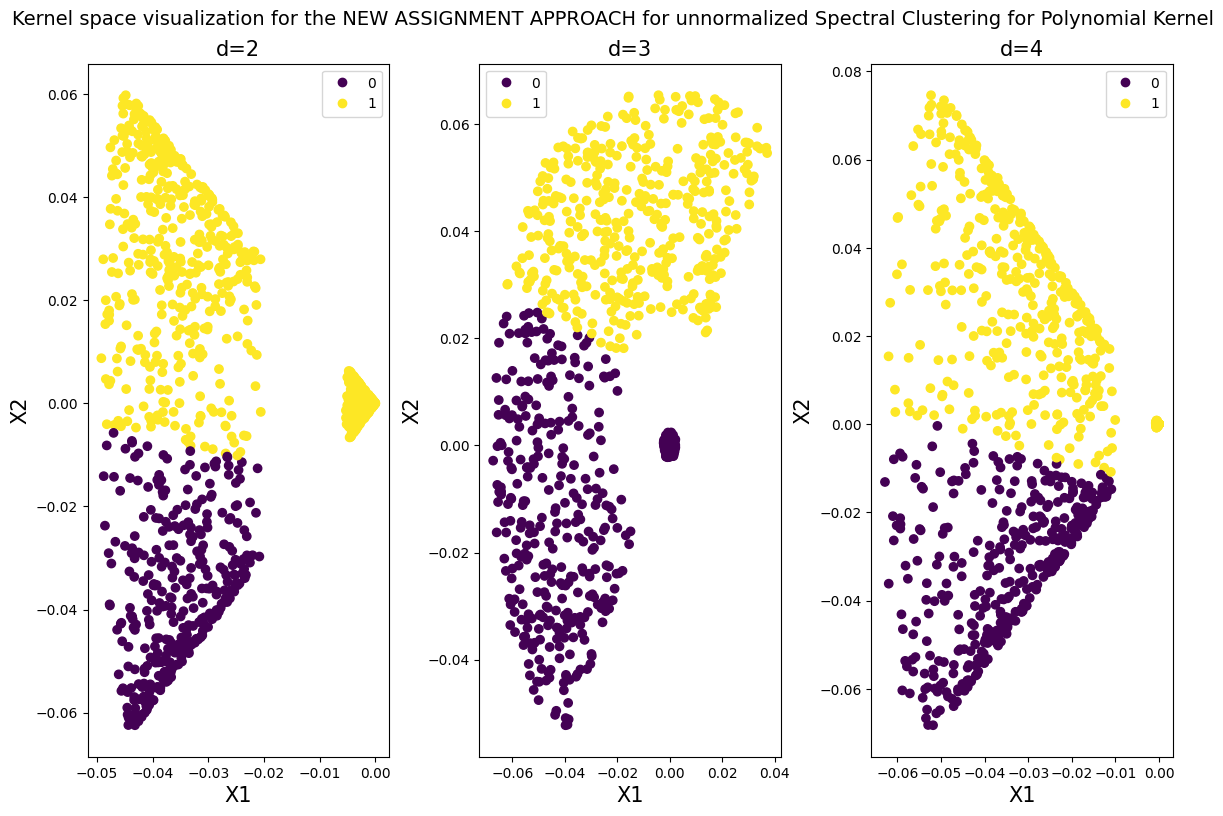

In [151]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Kernel space visualization for the NEW ASSIGNMENT APPROACH for unnormalized Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data_new_pol_un[i][:,0], data_new_pol_un[i][:,1],c=Z[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())

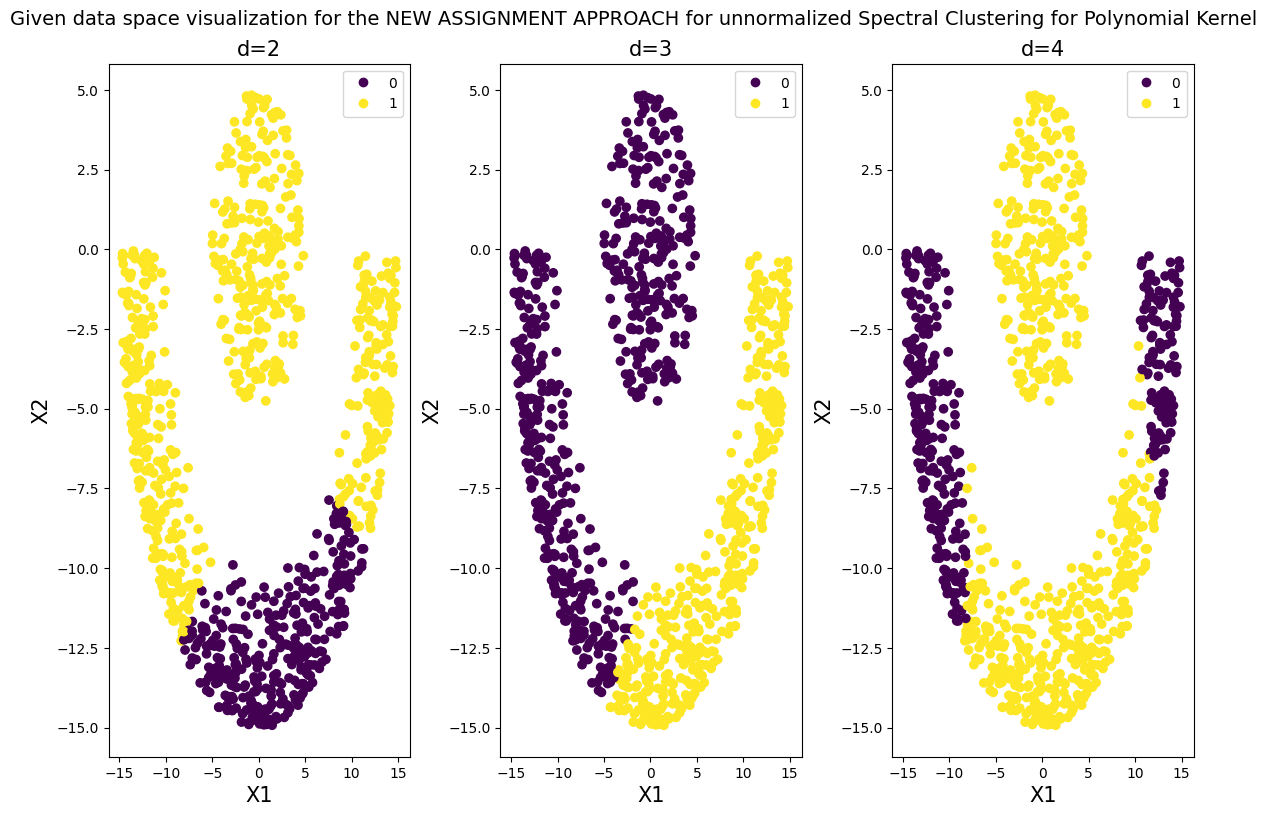

In [152]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(14,9))
fig.suptitle('Given data space visualization for the NEW ASSIGNMENT APPROACH for unnormalized Spectral Clustering for Polynomial Kernel',fontsize=14,x=0.5,y=0.94)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i,ax in enumerate(axs.flat):
  plot=ax.scatter(data[:,0], data[:,1],c=Z[i,:])
  ax.set_title(f'd={d_list[i]}',fontsize=15)
  ax.set_xlabel('X1',fontsize=15)
  ax.set_ylabel('X2',fontsize=15)
  ax.legend(*plot.legend_elements())